# 1 - Setup
This section includes all necessary imports, global variables, and configurations needed to set up the notebook for the rest of the project. It defines the default styles and parameters for plots, imports necessary libraries and sets any constants and configurations. The setup section also initializes any tools and services that will be used throughout the notebook.

## 1-1 - Imports

In [1]:
# Import any necessary packages and libraries for the project
# Built-in libraries
from collections import defaultdict
import pickle
import random
import os
import warnings

# Data analysis and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Machine learning libraries
import optuna
import mlflow

# Sklearn algorithms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

# Surprise algorithms
from surprise import Dataset, PredictionImpossible, Reader, accuracy
from surprise.model_selection import cross_validate, LeaveOneOut, train_test_split
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.prediction_algorithms.matrix_factorization import SVD, SVDpp
from surprise.prediction_algorithms.slope_one import SlopeOne 
from surprise.prediction_algorithms.co_clustering import CoClustering

# Other libraries
from prettytable import PrettyTable

## 1-2 - Globals

In [2]:
# Define any global variables that you will be using throughout the notebook
# File paths and directories
DATA_DIR = "/app/data"
ANIME_DATA = os.path.join(DATA_DIR, "anime.csv")
RATING_DATA = os.path.join(DATA_DIR, "rating.csv")
BENCHMARK_W_MINIMUM = os.path.join(DATA_DIR, "test_w_min_rating_benchmark.csv")
BENCHMARK_WO_MINIMUM = os.path.join(DATA_DIR, "test_wo_min_rating_benchmark.csv")
PKL_MODEL_DIR = os.path.join(DATA_DIR, "pkl_model")

# Default values and thresholds
FIG_SIZE = (15, 8)
TOP_N = 10
NB_CLUSTER = 10
THRESHOLD = 6
USER_ID = 244
MAX_USER_RATING = 500
MAX_RATINGS_PER_ANIME = 5000
MIN_RATING = 100
WITH_MINIMUM = True

# MLflow & optuna configuration
OPTUNA_DB = "sqlite:///db.sqlite3"
EXPERIMENT = "p_test_w_min_rating" # _wo_min_rating
N_TRIAL = 1
PATIENCE = 2

## 1-3 - Style

In [3]:
def set_default(
    style: str='darkgrid',
    figsize: tuple=FIG_SIZE,
    dpi: int=100):
    """
    Set default seaborn style, figure size, and dpi.

    Args:
    - style (str): Name of seaborn style to use (default is 'darkgrid').
    - figsize (tuple): Figure size in inches as a tuple (default is FIG_SIZE).
    - dpi (int): Dots per inch for figure resolution (default is 100).

    Returns:
    None
    """
    sns.set_style(style)
    # Set figure size and dpi
    sns.set(rc={'figure.figsize':figsize, 'figure.dpi':dpi})

In [4]:
# Define any custom styles and formatting for the notebook
%matplotlib inline
set_default()

## 1-4 - Dashboard

In [5]:
# Create an instance of the MlflowClient class to communicate with the tracking server
client = mlflow.MlflowClient()

# To view the Mlflow dashboard, run the command below in the terminal:
# mlflow ui --host localhost --port 5002
# This will start the dashboard on localhost:5002, allowing you to view your experiments and runs in a web interface.

# To view the Optuna dashboard, run the command below in the terminal:
# optuna-dashboard sqlite:///db.sqlite3
# This will start the dashboard on 127.0.0.1:8080, allowing you to view your hyperparameters tuning and runs in a web interface.

# 2 - Load data
This section is dedicated to loading the data required for the project. The section then uses the 'load_csv' method to read the anime and rating data from CSV files and store them in Pandas dataframes. A copy of each dataframe is also created for exploratory purposes, to prevent any modifications to the original dataframes. 


In [6]:
def load_csv(path: str) -> pd.DataFrame:
    """
    Load a CSV file as a pandas DataFrame.

    Args:
    - path (str): The path to the CSV file.

    Returns:
    - pd.DataFrame: A pandas DataFrame containing the CSV data.

    Raises:
    - FileNotFoundError: If the file is not found at the specified path.

    """
    try:
        return pd.read_csv(path)
    except FileNotFoundError:
        print("File not found")

In [7]:
anime_df = load_csv(ANIME_DATA)

In [8]:
rating_df = load_csv(RATING_DATA)

In [9]:
# Create copy of anime and rating dataframes for exploratory analysis
anime = anime_df.copy()
rating = rating_df.copy()

# 3 - Exploratory Data Analysis (EDA)
In this section, we will explore the datasets and gain a deeper understanding of the characteristics of the data we're working with. 
We will visualize the distribution of the ratings, explore relationships between the features, and identify any patterns or outliers in the data. 
This step is critical to identify any issues with the data and inform our modeling decisions later on.

In [10]:
def display_distribution(
    df: pd.DataFrame,
    column_name: str,
    density_plot: bool=False,
    figsize: tuple[int, int]=FIG_SIZE
) -> None:
    """
    Displays a distribution plot of the specified column in the given DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame to plot.
    - column_name (str): The name of the column to plot.
    - ensity_plot (bool, optional): Whether to display a density plot instead of a histogram. Defaults to False.
    - figsize (Tuple[int, int], optional): The size of the figure to display. Defaults to FIG_SIZE.

    Returns:
    None
    """
    if density_plot:
        # Create a kernel density estimate plot
        sns.kdeplot(df[column_name])
    else:
        # Create a histogram plot
        sns.displot(df[column_name], height=figsize[1], aspect=figsize[0]/figsize[1])
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column_name}')
    plt.show()

## 3-1 - Anime

In [11]:
def display_anime_info():
    """
    Displays information about the anime dataframe columns.

    Args:
    None

    Returns:
    None
    """
    table = PrettyTable()
    table.field_names = ["Column", "Description"]
    table.add_row(['anime_id', 'myanimelist.net\'s unique id identifying an anime'])
    table.add_row(['name', 'full name of anime'])
    table.add_row(['genre', 'comma separated list of genres for this anime'])
    table.add_row(['type', 'movie, TV, OVA, etc'])
    table.add_row(['episodes', 'how many episodes in this show. (1 if movie)'])
    table.add_row(['rating', 'average rating out of 10 for this anime'])
    table.add_row(['members', 'number of community members that are in this anime\'s "group"'])
    print(table)

In [12]:
anime.head() 

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [13]:
display_anime_info()

+----------+--------------------------------------------------------------+
|  Column  |                         Description                          |
+----------+--------------------------------------------------------------+
| anime_id |       myanimelist.net's unique id identifying an anime       |
|   name   |                      full name of anime                      |
|  genre   |        comma separated list of genres for this anime         |
|   type   |                     movie, TV, OVA, etc                      |
| episodes |         how many episodes in this show. (1 if movie)         |
|  rating  |           average rating out of 10 for this anime            |
| members  | number of community members that are in this anime's "group" |
+----------+--------------------------------------------------------------+


In [14]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


We loaded the anime data and examined its structure and content. We now have a good understanding of what the data represents and the data types of each column. However, we can see from the output of anime.info() that there are some missing values in the *genre*, *type*, and *rating* columns, which may need to be addressed before proceeding with analysis.

### Modify *episodes*
We can see that *episodes* is an object instead of a int, let's see:

In [15]:
anime.episodes.dtype

dtype('O')

In [16]:
anime.episodes.unique()

array(['1', '64', '51', '24', '10', '148', '110', '13', '201', '25', '22',
       '75', '4', '26', '12', '27', '43', '74', '37', '2', '11', '99',
       'Unknown', '39', '101', '47', '50', '62', '33', '112', '23', '3',
       '94', '6', '8', '14', '7', '40', '15', '203', '77', '291', '120',
       '102', '96', '38', '79', '175', '103', '70', '153', '45', '5',
       '21', '63', '52', '28', '145', '36', '69', '60', '178', '114',
       '35', '61', '34', '109', '20', '9', '49', '366', '97', '48', '78',
       '358', '155', '104', '113', '54', '167', '161', '42', '142', '31',
       '373', '220', '46', '195', '17', '1787', '73', '147', '127', '16',
       '19', '98', '150', '76', '53', '124', '29', '115', '224', '44',
       '58', '93', '154', '92', '67', '172', '86', '30', '276', '59',
       '72', '330', '41', '105', '128', '137', '56', '55', '65', '243',
       '193', '18', '191', '180', '91', '192', '66', '182', '32', '164',
       '100', '296', '694', '95', '68', '117', '151', '130',

In [17]:
def change_episodes_to_int(df: pd.DataFrame) -> pd.DataFrame:
    """
    Changes the data type of the 'episodes' column in a Pandas DataFrame
    from object to int. 'Unknown' values are replaced with NaN, and NaN
    values are filled with -1 before conversion to int.
    
    Args:
    - df (pd.DataFrame): The DataFrame to modify.
    
    Returns:
    - pd.DataFrame: The modified DataFrame.
    """
    # Replace 'Unknown' values with NaN
    df['episodes'] = df['episodes'].replace('Unknown', np.nan)
    # Fill in NaN values with -1
    df['episodes'] = df['episodes'].fillna(-1)
    # Convert episodes to int data type
    df['episodes'] = df['episodes'].astype(int)
    return df

In [18]:
anime = change_episodes_to_int(anime)

### Modify *genres*
There seems to be a large number of combinations of genre, it would be interesting to group the genre:

In [19]:
anime.genre.info()

<class 'pandas.core.series.Series'>
RangeIndex: 12294 entries, 0 to 12293
Series name: genre
Non-Null Count  Dtype 
--------------  ----- 
12232 non-null  object
dtypes: object(1)
memory usage: 96.2+ KB


In [20]:
anime.genre.unique()

array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       ..., 'Hentai, Sports', 'Drama, Romance, School, Yuri',
       'Hentai, Slice of Life'], dtype=object)

In [21]:
anime.genre.unique().size

3265

There is 3265 genre! That's to much. Let's juste create 10 categories with clustering method:

In [22]:
def cluster_anime(df: pd.DataFrame, nb_cluster: int = NB_CLUSTER) -> pd.DataFrame:
    """
    Cluster anime data based on their genres using K-means algorithm with the given number of clusters.

    Args:
    - df (pd.DataFrame): The input DataFrame to cluster.
    - nb_cluster (int): The number of clusters to create. Default is 10.

    Returns:
    - pd.DataFrame: A new DataFrame with added 'cluster' and 'cluster_name' columns that represent
                    the cluster label and the cluster name of each anime, respectively.
    """
    # Replace missing values with an empty string
    df['genre'].fillna('', inplace=True)
    
    # Create a TfidfVectorizer object with stop words removed
    tfidf = TfidfVectorizer(stop_words='english')
    
    # Transform the genre column of the anime dataframe into a sparse matrix of TF-IDF features
    X = tfidf.fit_transform(df['genre'])
    
    # Apply K-means with the given number of clusters
    kmeans = KMeans(n_clusters=nb_cluster, random_state=0, n_init=nb_cluster)
    kmeans.fit(X)
    
    # Retrieve cluster labels for each genre
    labels = kmeans.labels_
    
    # Find the most representative genres for each cluster
    top_genres = []
    for i in range(nb_cluster):
        cluster_genres = df.iloc[labels == i]['genre'].str.cat(sep=',').split(',')
        genre_counts = pd.Series(cluster_genres).value_counts()
        top_genre = genre_counts.index[0]
        top_genres.append(top_genre)
        
    # Associate each label value with a cluster name based on the most representative gender
    label_names = {}
    for i in range(nb_cluster):
        label_names[i] = top_genres[i]
        
    # Add cluster labels to the initial dataframe
    df['cluster'] = labels
    
    # Replace numeric cluster labels with specific cluster names
    df['cluster_name'] = df['cluster'].map(label_names)
    
    return df

In [23]:
anime = cluster_anime(anime)

### 3-1-1 - Visualize some distributions

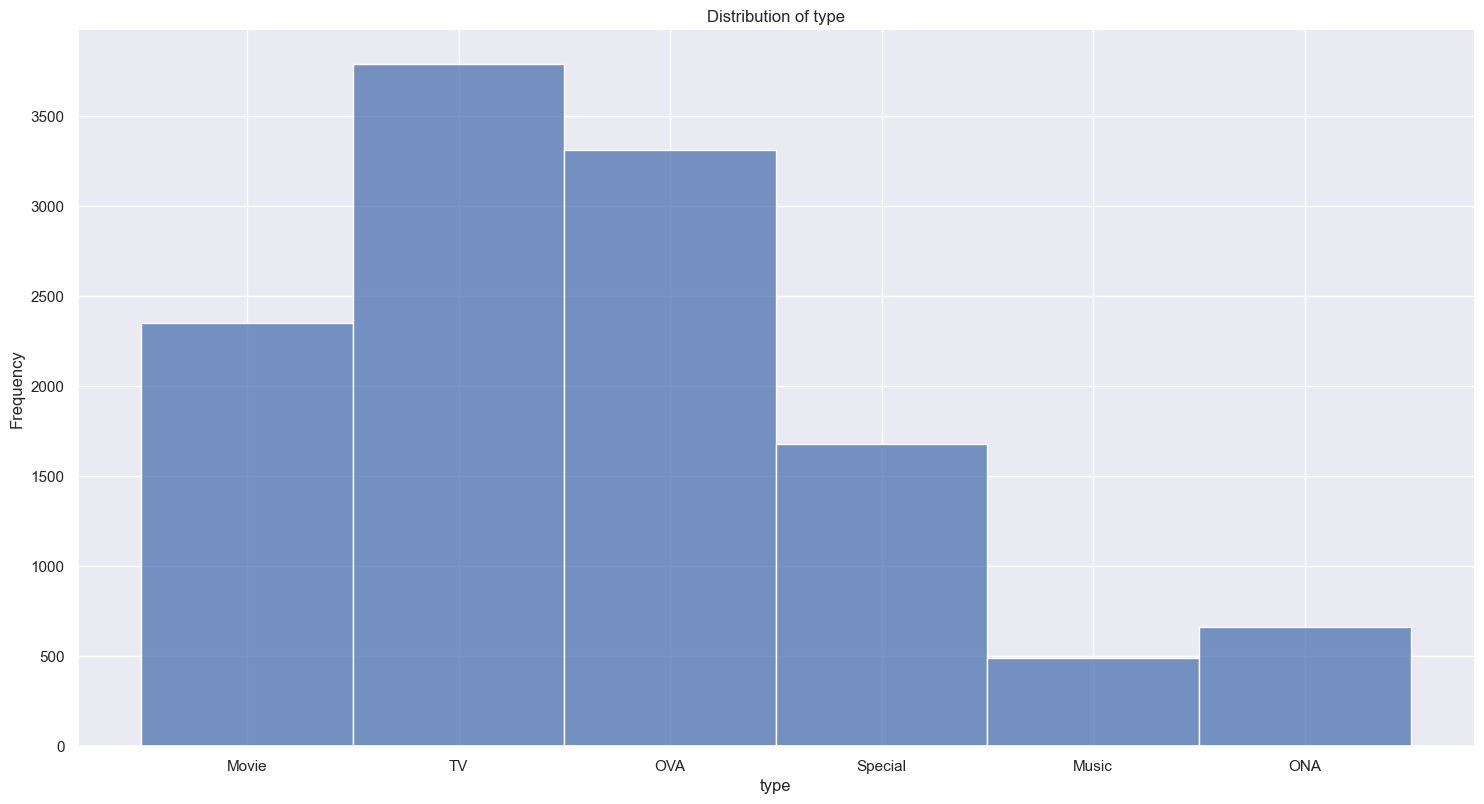

In [24]:
# Distribution of type
display_distribution(anime, 'type')

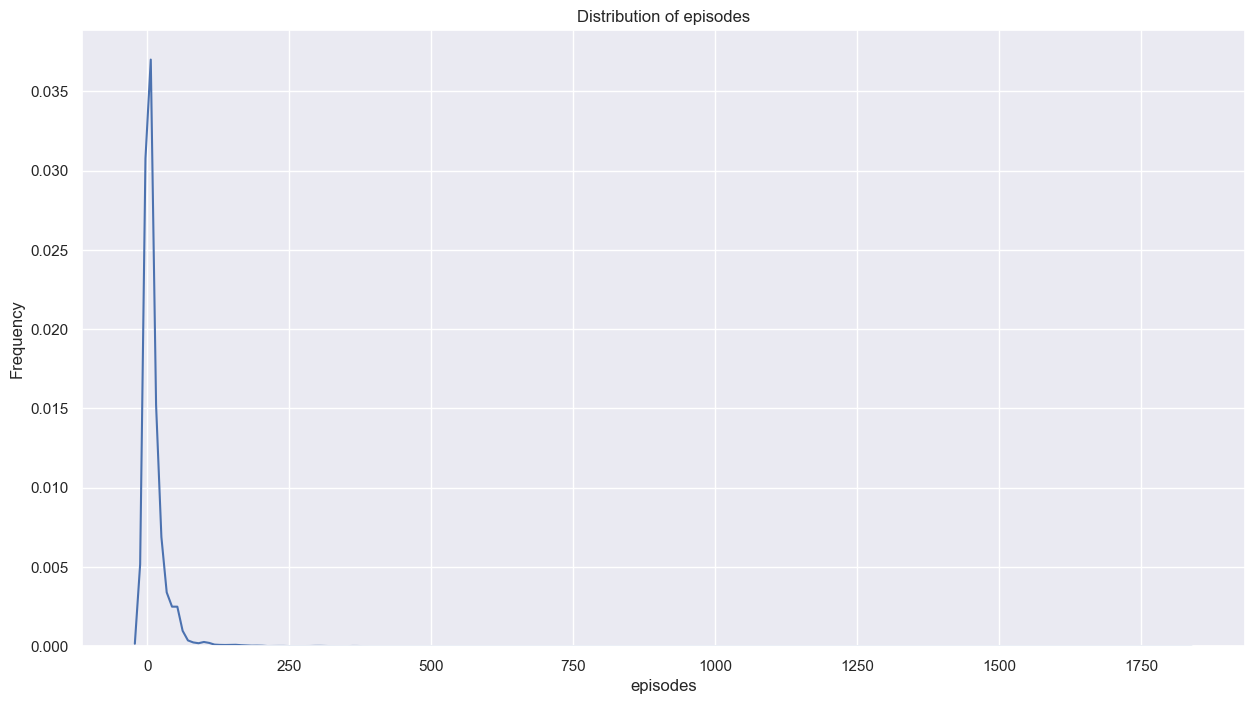

In [25]:
# Distribution of episodes
display_distribution(anime, 'episodes', density_plot=True)

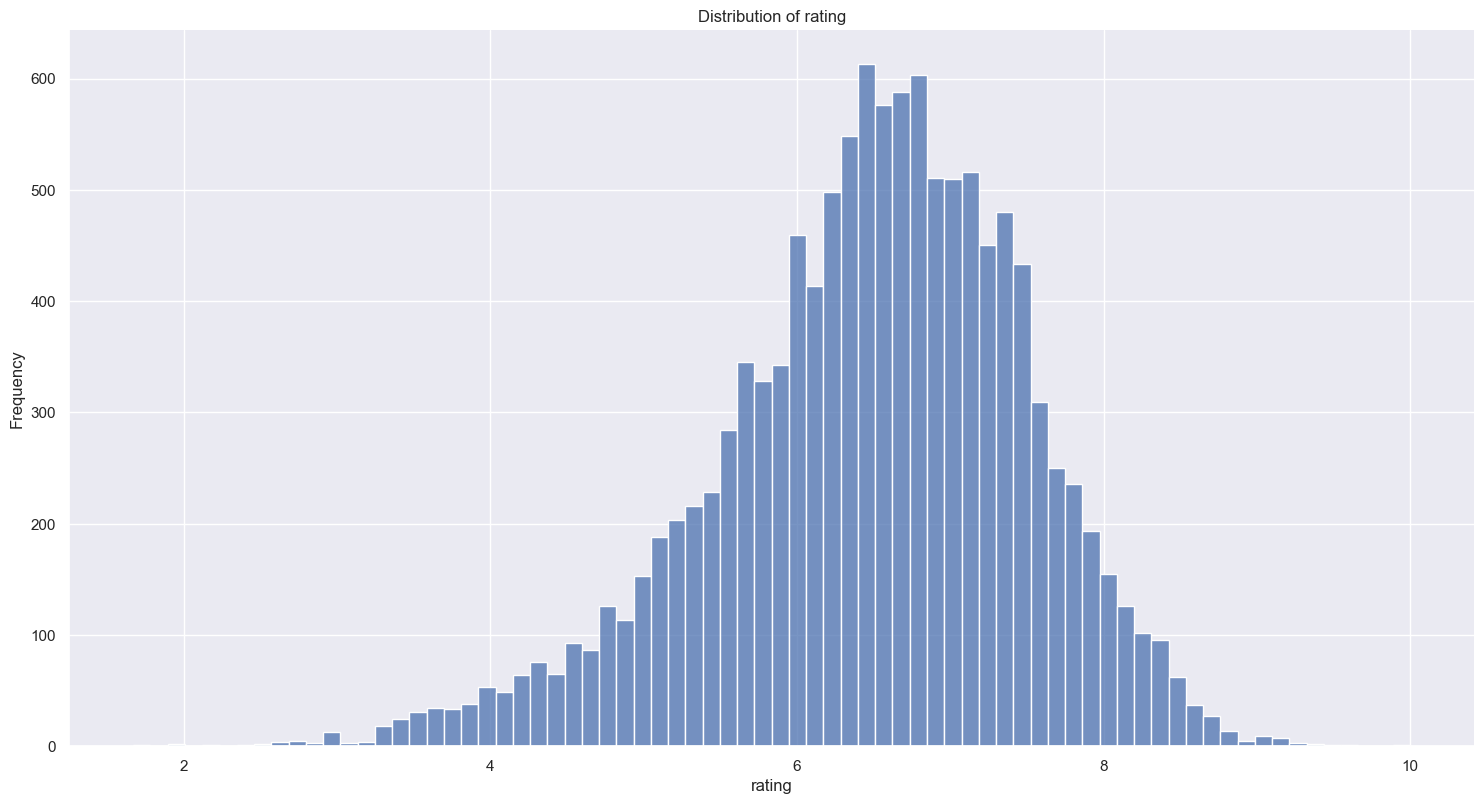

In [26]:
# Distribution of rating
display_distribution(anime, 'rating')

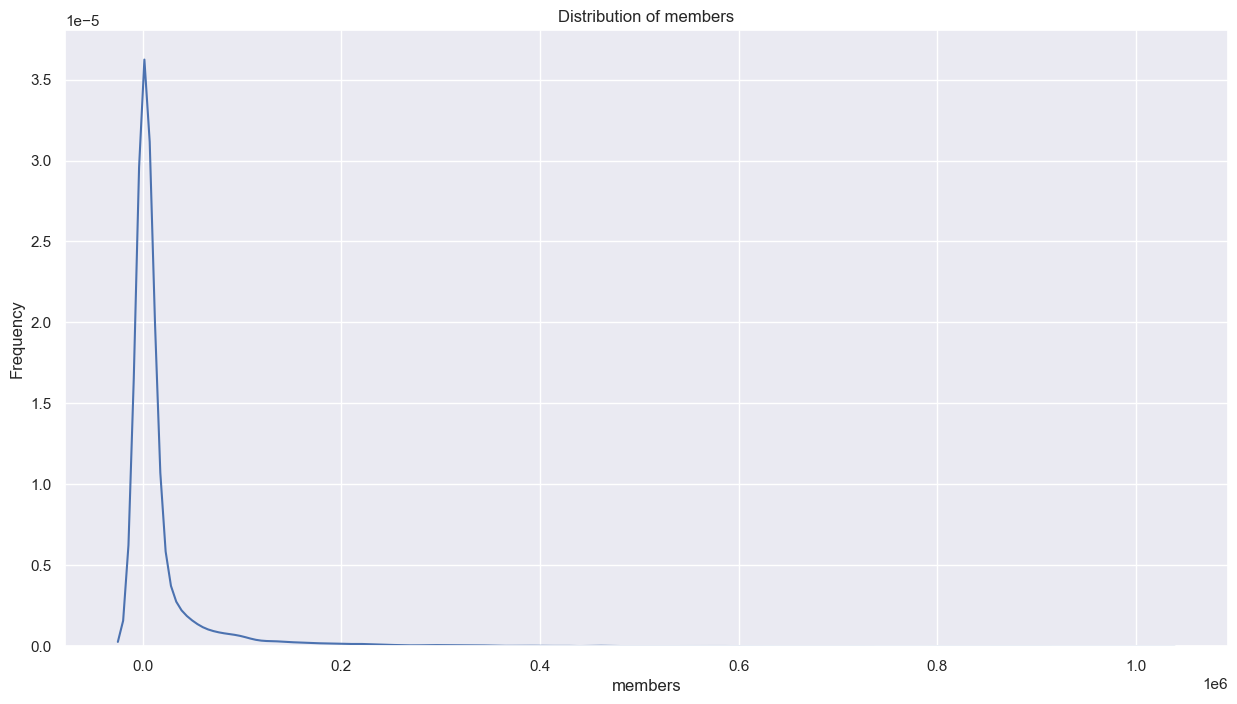

In [27]:
# Distribution of rating
display_distribution(anime, 'members', density_plot=True)

Based on the visualizations of the distributions, we can draw several conclusions about the anime dataset.

First, we can see that the majority of anime in the dataset are TV shows, OVAs, and movies.

Secondly, the distribution of episodes is heavily skewed towards lower episode counts, with the majority of anime having less than 100 episodes. However, the x-axis of the plot extends up to 1800 episodes, indicating that there are some anime with much higher episode counts that are outliers in the dataset.

Thirdly, the distribution of ratings appears to be roughly normal with a peak around 6.5/10, indicating that there are many average-rated anime in the dataset, with fewer anime being highly rated or poorly rated.

Lastly, the distribution of members is heavily skewed towards lower member counts, with the majority of anime having less than 0.2 million members. This suggests that there are many niche anime in the dataset that have a small but dedicated fanbase, with fewer anime being popular enough to have a large number of members.

### 3-1-2 - Genre-by-genre study

In [28]:
def rank_anime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds rank variables for average score and number of scores to a given Pandas DataFrame.
    
    Args:
    - df (pd.DataFrame): The DataFrame to modify.
    
    Returns:
    - pd.DataFrame: The modified DataFrame.
    """
    # Add rank variable for average score
    # This variable allows us to compare the popularity of anime based on their average score
    df['score_rank'] = df['rating'].rank(method='dense', ascending=False)

    # Add rank variable for number of scores
    # This variable allows us to compare the popularity of anime based on the number of members who have added it to their list
    df['members_rank'] = df['members'].rank(method='dense', ascending=False)
    
    return df

In [29]:
def group_anime(
    df: pd.DataFrame,
    column_name: str
) -> pd.DataFrame:
    """
    Groups the anime DataFrame by a specified column name, and calculates
    the average rating and number of ratings for each group. Adds rank
    variables for average rating and number of ratings.

    Args:
    - df (pd.DataFrame): The DataFrame to modify.
    - column_name (str): The name of the column to group by.

    Returns:
    - pd.DataFrame: A new DataFrame with the following columns:
        - column_name: The name of the group.
        - avg_rating: The average rating of all anime in the group.
        - num_ratings: The total number of ratings for all anime in the group.
        - avg_rating_rank: The rank of the group based on average rating.
        - num_ratings_rank: The rank of the group based on number of ratings.
    """
    # Group the anime by column_name
    df_grouped = df.groupby(column_name)

    # Calculate the average rating and number of ratings for each group
    avg_rating = df_grouped['rating'].mean()
    num_ratings = df_grouped['members'].sum()

    # Create a new dataframe to store the results
    stats = pd.DataFrame({'avg_rating': avg_rating, 'num_ratings': num_ratings})

    # Add the rank variables to the dataframe
    stats['avg_rating_rank'] = stats['avg_rating'].rank(ascending=False)
    stats['num_ratings_rank'] = stats['num_ratings'].rank(ascending=False)

    return stats

In [30]:
def plot_topN(
    df: pd.DataFrame,
    column_name: str,
    topN:int = TOP_N
) -> None:
    """
    Plots the top N genres based on a specified column in a Pandas DataFrame.

    Args:
    - df (pd.DataFrame): The DataFrame containing the data to plot.
    - column_name (str): The name of the column to use for ranking the genres.
    - topN (int, optional): The number of top genres to plot. Defaults to the global constant TOP_N.

    Returns:
    - None
    """
    top_N = df.sort_values(by=column_name, ascending=False).head(topN)
    sns.barplot(x=top_N.index, y=top_N[column_name])
    plt.xticks(rotation=90)
    plt.xlabel('Genre')
    plt.ylabel(column_name)
    plt.title(f'Top {topN} genres by {column_name}')
    plt.show()

In [31]:
anime = rank_anime(anime)

In [32]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members,cluster,cluster_name,score_rank,members_rank
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,1,Comedy,4.0,217.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,0,Fantasy,6.0,4.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,4,Sci-Fi,7.0,472.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,4,Sci-Fi,8.0,8.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,4,Sci-Fi,9.0,334.0


In [33]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   anime_id      12294 non-null  int64  
 1   name          12294 non-null  object 
 2   genre         12294 non-null  object 
 3   type          12269 non-null  object 
 4   episodes      12294 non-null  int32  
 5   rating        12064 non-null  float64
 6   members       12294 non-null  int64  
 7   cluster       12294 non-null  int32  
 8   cluster_name  12294 non-null  object 
 9   score_rank    12064 non-null  float64
 10  members_rank  12294 non-null  float64
dtypes: float64(3), int32(2), int64(2), object(4)
memory usage: 960.6+ KB


In [34]:
genre_stats = group_anime(anime, 'cluster_name')
genre_stats

,avg_rating,num_ratings,avg_rating_rank,num_ratings_rank
cluster_name,,,,
Fantasy,6.648840,30035097,4.0,5.0
Historical,6.683778,8342774,2.0,6.0
Kids,6.080019,887659,8.0,9.0
Sci-Fi,6.679726,35530552,3.0,3.0
Slice of Life,6.725185,31313345,1.0,4.0
Action,6.504209,59854997,6.0,1.0
Comedy,6.522813,51733240,5.0,2.0
Hentai,6.197189,2731178,7.0,7.0
Music,5.684352,1740198,9.0,8.0


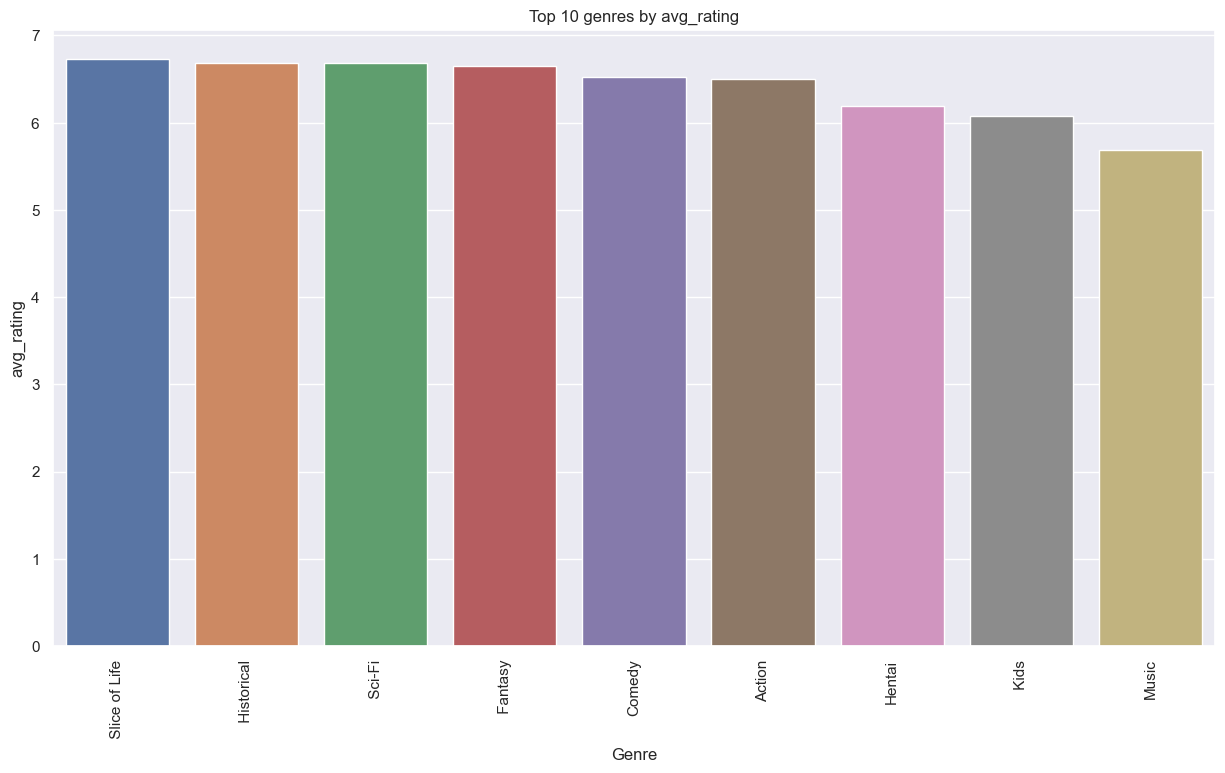

In [35]:
plot_topN(genre_stats, 'avg_rating')

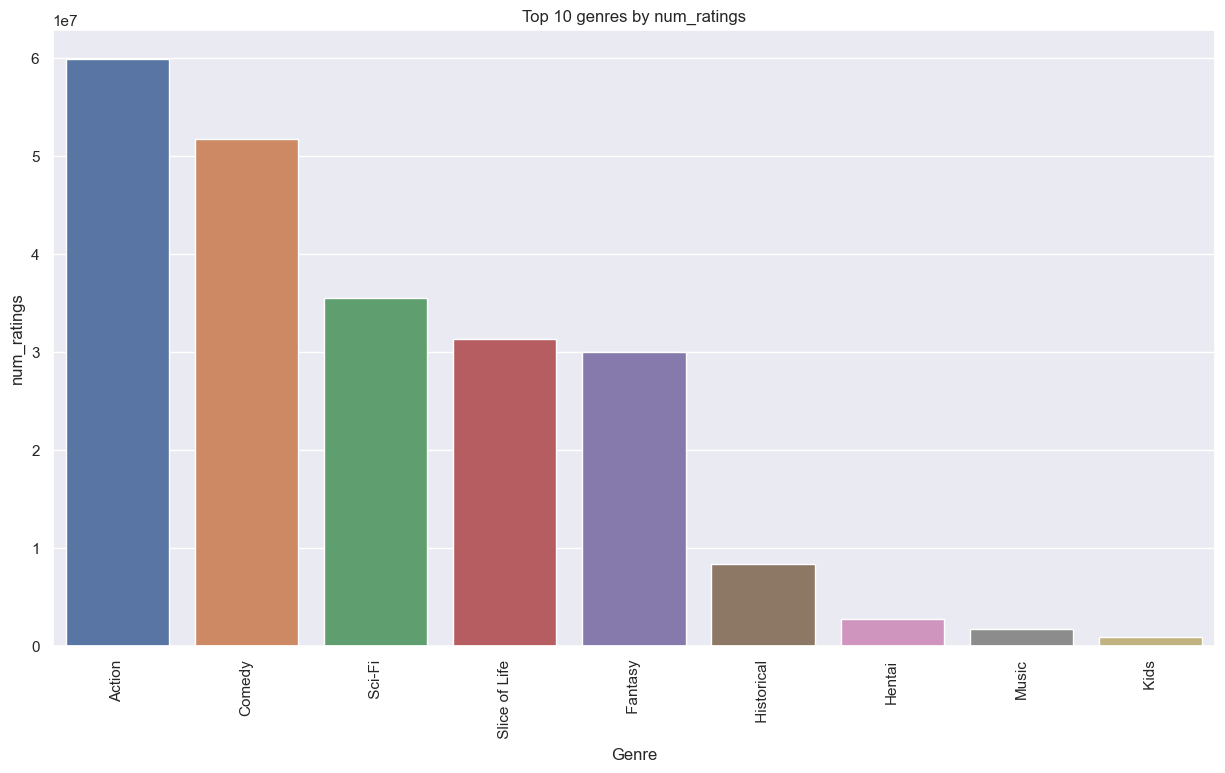

In [36]:
plot_topN(genre_stats, 'num_ratings')

In [37]:
type_stats = group_anime(anime, 'type')
type_stats

,avg_rating,num_ratings,avg_rating_rank,num_ratings_rank
type,,,,
Movie,6.318058,24326080,4.0,2.0
Music,5.588996,640178,6.0,6.0
ONA,5.643298,2711146,5.0,5.0
OVA,6.375221,19820109,3.0,3.0
Special,6.523501,12865078,2.0,4.0
TV,6.902299,161643014,1.0,1.0


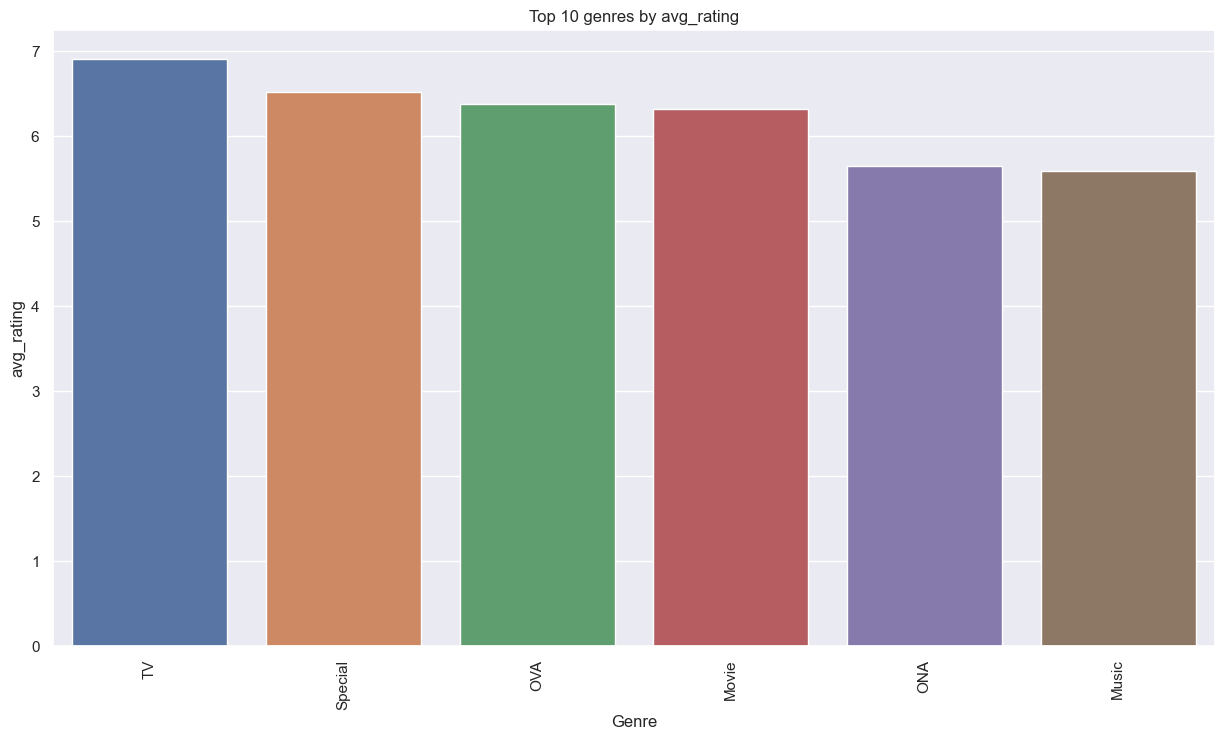

In [38]:
plot_topN(type_stats, 'avg_rating')

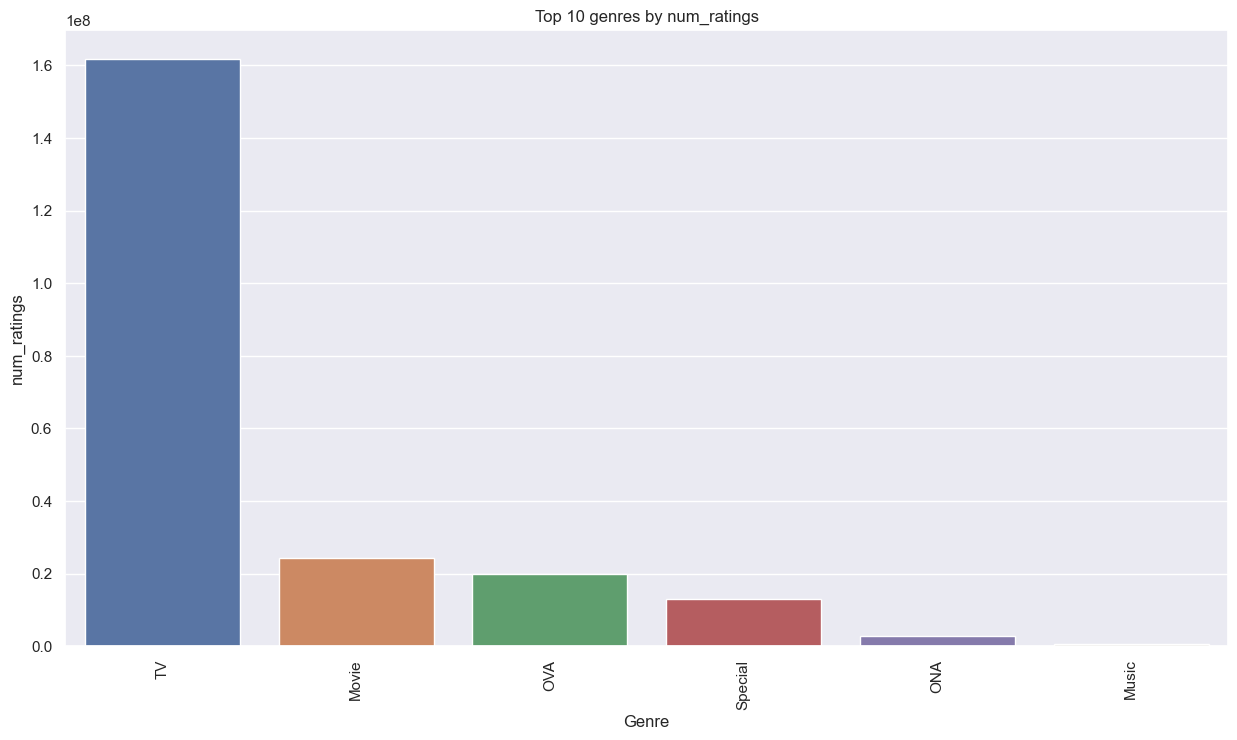

In [39]:
plot_topN(type_stats, 'num_ratings')

Based on the analysis, we can conclude that for the genre, the top 3 most popular genres in terms of number of members are action, comedy, and scifi, while the top 3 genres with the highest average rating are slice of life, historical, and sci-fi. However, the difference in average rating between genres is not significant, and there is a large overlap in popularity between genres.

For the type of anime, the most popular type is TV series with the highest number of members, followed by movies and OVAs. However, the average rating is relatively similar between different types of anime, with TV series being slightly higher. It is also worth noting that the number of members for the different types of anime varies greatly, with TV series having the most members by a large margin.

Overall, it can be concluded that popularity and average rating are not necessarily correlated, and different types and genres of anime can have a wide range of popularity and ratings.

### 3-1-3 - Conclusion for EDA in anime dataset
Based on the exploratory data analysis (EDA) performed on the anime dataset, we can draw the following conclusions:

- The majority of anime in the dataset are of the TV type, followed by OVA and movies.
- The distribution of episodes shows that the majority of anime have less than 100 episodes, with a long tail indicating a few outliers with significantly more episodes.
- The distribution of ratings is roughly normal with a peak around 6.5/10, indicating that most anime in the dataset are rated around this score.
- The distribution of members shows that there are a few extremely popular anime with millions of members, while the majority have relatively few members.
- Slice of life and historical anime tend to have higher average ratings, while action and comedy anime tend to have more members.
- TV anime are the most popular in terms of number of members, followed by movies, OVA, specials, and music anime.

## 3-2 - Rating

In [40]:
def display_rating_info():
    """
    Prints a table with information about the rating dataset columns.
    """
    table = PrettyTable()
    table.field_names = ["Column", "Description"]
    table.add_row(['user_id', 'non identifiable randomly generated user id'])
    table.add_row(['anime_id', 'the anime that this user has rated'])
    table.add_row(['rating', 'rating out of 10 this user has assigned (-1 if the user watched it but didn\'t assign a rating)'])
    print(table)

In [41]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [42]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [43]:
display_rating_info()

+----------+------------------------------------------------------------------------------------------------+
|  Column  |                                          Description                                           |
+----------+------------------------------------------------------------------------------------------------+
| user_id  |                          non identifiable randomly generated user id                           |
| anime_id |                               the anime that this user has rated                               |
|  rating  | rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating) |
+----------+------------------------------------------------------------------------------------------------+


### 3-1-1 - Add some relevant data
We can add user ratings and rating per anime values in the dataframe.

For simplicity just remove *-1 rating* (the user watched it but didn't assign a rating) and also we need to remove *anime_id* that's not in *anime* dataframe:

In [44]:
def remove_non_rating(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove non-rating values from the rating DataFrame.
    
    Args:
    - rating (pd.DataFrame): The rating DataFrame.
    
    Returns:
    - pd.DataFrame: The rating DataFrame without non-rating values.
    """
    df['rating'] = df['rating'].replace(-1, np.nan)
    df = df.dropna()
    
    return df

In [45]:
def remove_non_anime(
    df_r: pd.DataFrame,
    df_a: pd.DataFrame
) -> pd.DataFrame:
    """
    Removes anime that have no ratings from the anime DataFrame by merging with the rating DataFrame.

    Args:
    - df_r (pd.DataFrame): DataFrame containing the user ratings.
    - df_a (pd.DataFrame): DataFrame containing the anime information.

    Returns:
    - pd.DataFrame: DataFrame with only the anime that have at least one rating and their corresponding user ratings.
    """
    # merge the rating and anime DataFrames on anime_id
    merged_df = df_a.merge(df_r, on='anime_id', how='inner')
    # create a new DataFrame with only the user_id, anime_id, and rating columns
    df_r = merged_df[['user_id', 'anime_id', 'rating_y']]
    # rename the rating_y column to rating for consistency
    df_r = df_r.rename(columns={'rating_y': 'rating'})
    
    return df_r

In [46]:
def create_new_data_for_rating(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Creates new dataframes for user ratings and ratings per anime based on the given rating dataframe.

    Args:
    -df (pd.DataFrame): A dataframe containing user ratings for anime.

    Returns:
    - tuple[pd.DataFrame, pd.DataFrame]: A tuple containing two dataframes:
        - user_ratings: A dataframe with the count of ratings each user has given.
        - ratings_per_anime: A dataframe with the count of ratings each anime has received.
    """
    # Create a dataframe with the count of ratings each user has given
    user_ratings = pd.DataFrame({'ratings': df.groupby('user_id')['rating'].count()})
    
    # Create a dataframe with the count of ratings each anime has received
    ratings_per_anime = pd.DataFrame({'count': df.groupby('anime_id').size()})
    
    return user_ratings, ratings_per_anime

In [47]:
rating = remove_non_rating(rating)

In [48]:
rating = remove_non_anime(rating, anime)

In [49]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6337239 entries, 0 to 6337238
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 193.4 MB


In [50]:
# Create new data
user_ratings, ratings_per_anime = create_new_data_for_rating(rating)

### 3-1-2 - Visualize some distributions

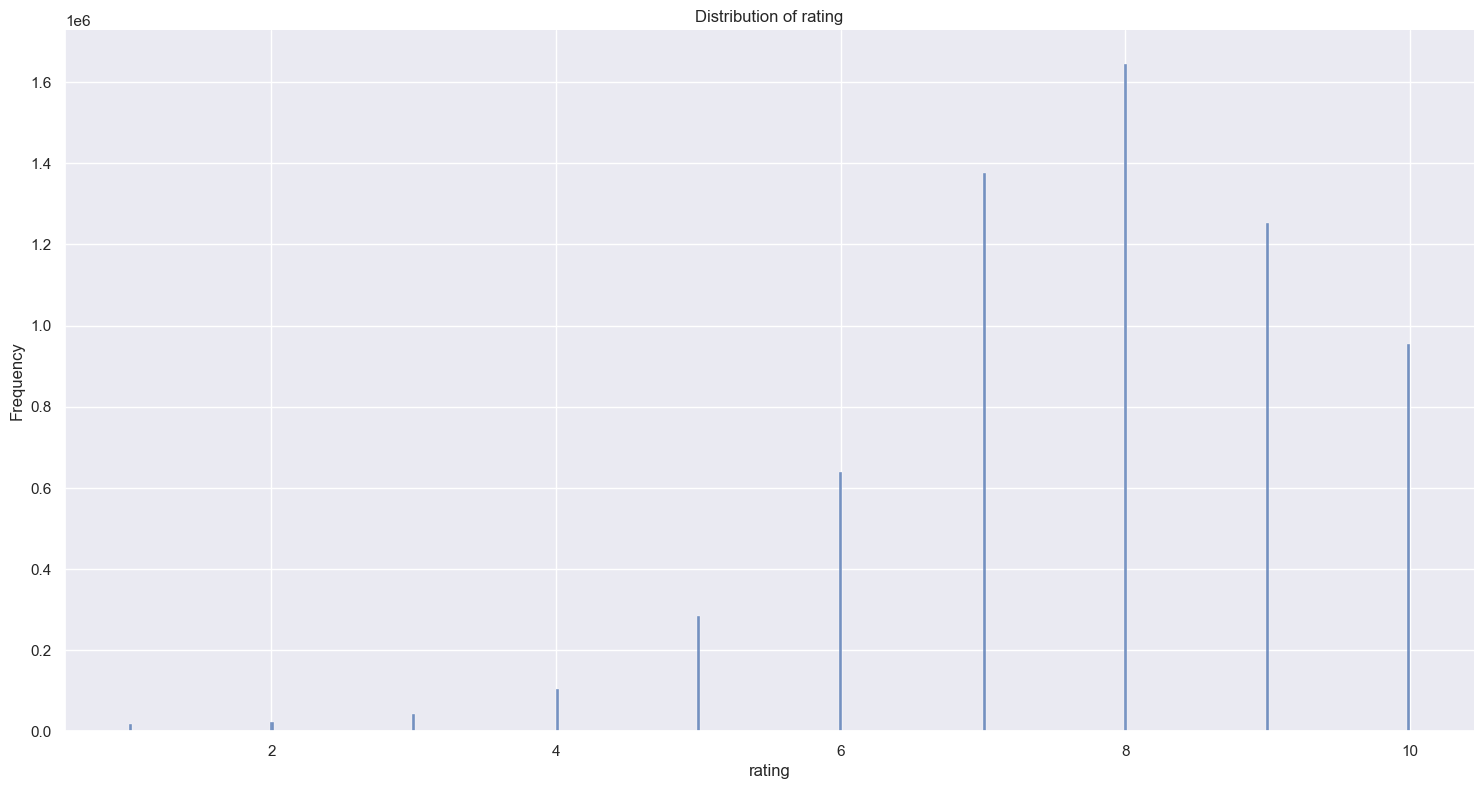

In [51]:
# Distribution of rating
display_distribution(rating, 'rating')

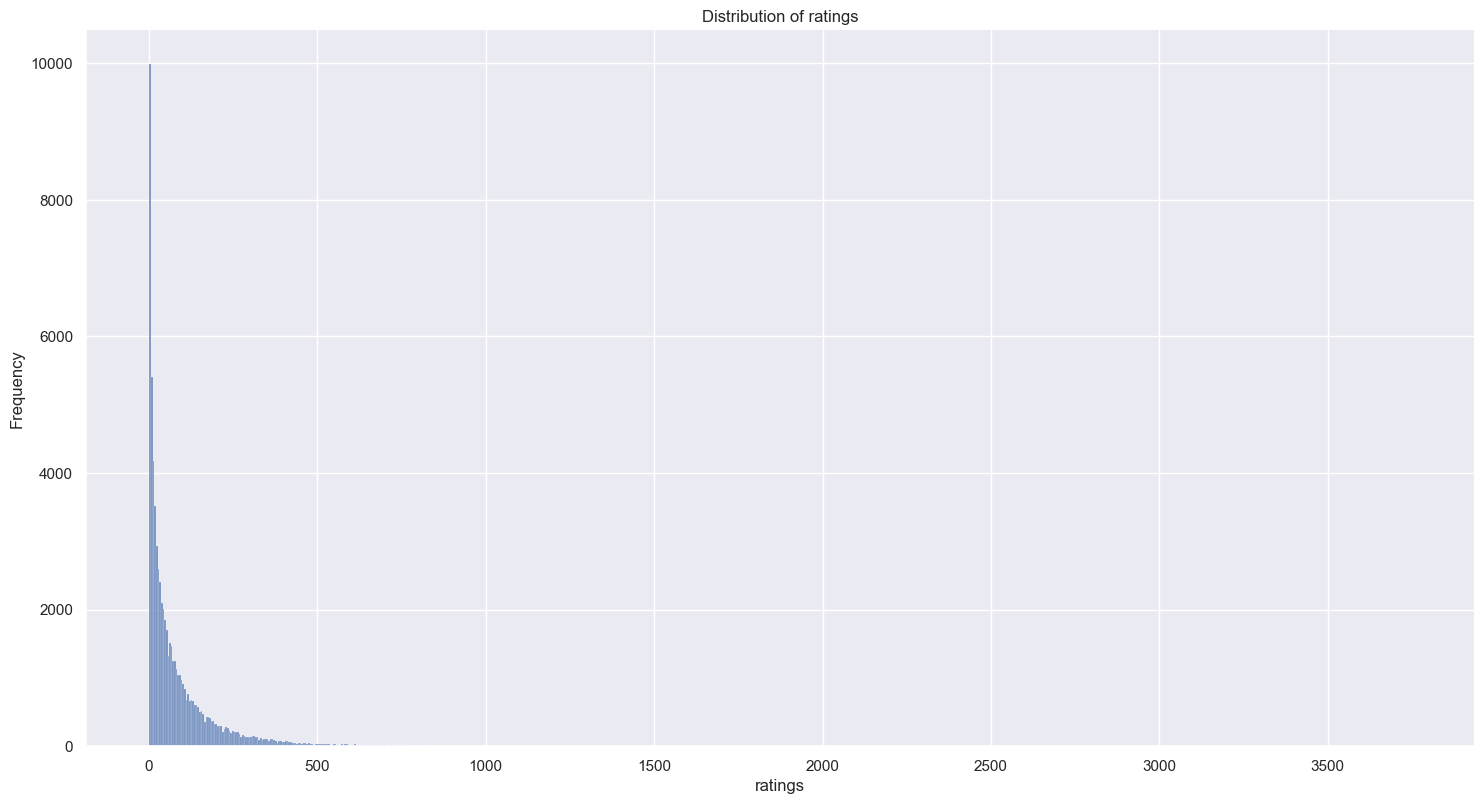

In [52]:
# Distribution of user_ratings
display_distribution(user_ratings, 'ratings')

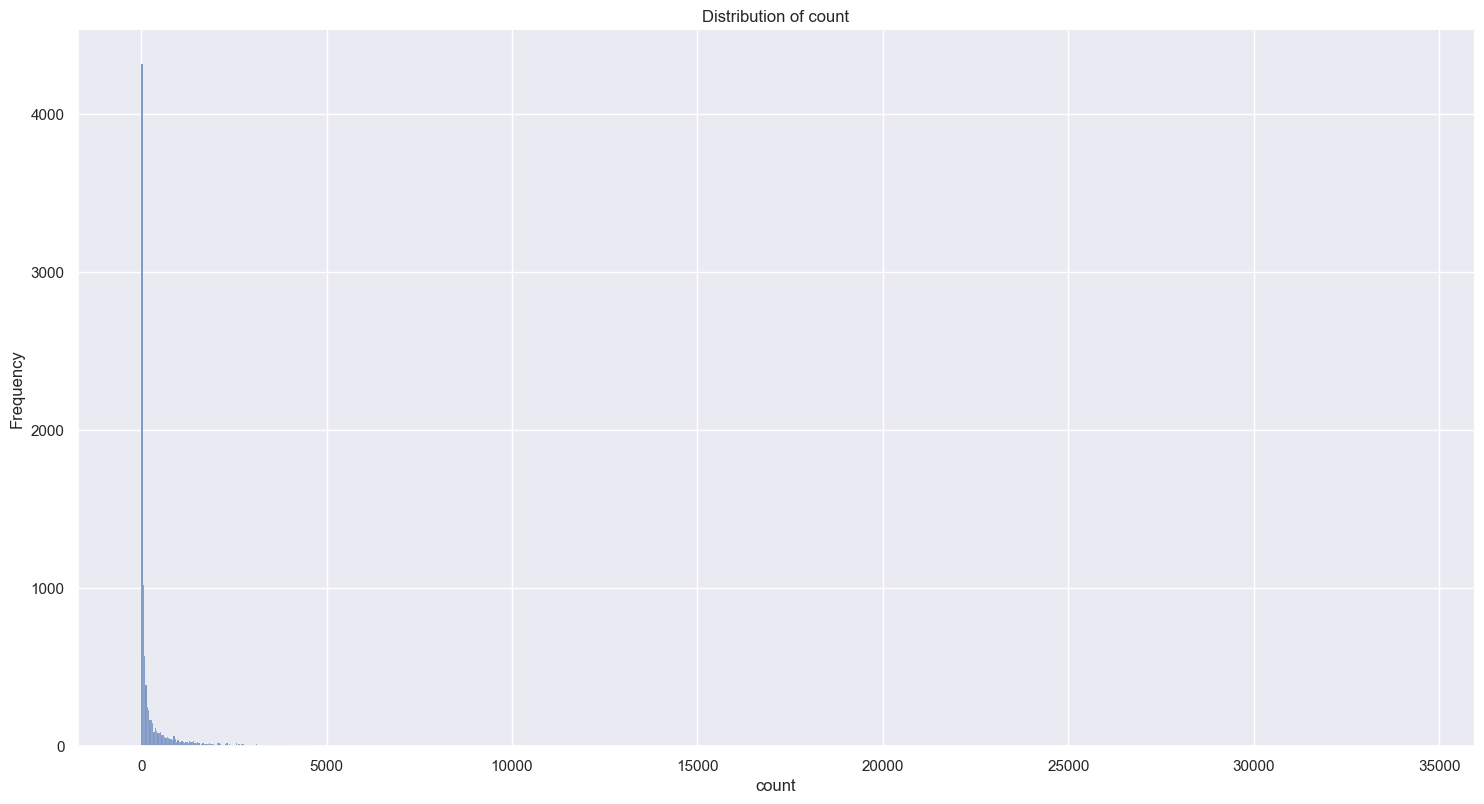

In [53]:
# Distribution of ratings_per_anime
display_distribution(ratings_per_anime, 'count')

Based on the visualizations, we can see that the rating distribution has a peak at 8/10, which suggests that users tend to rate anime they have watched more positively.

The distribution of user ratings shows that there are a large number of users who have rated very few anime (0 to 500), but there are also some users who have rated a significant number of anime (up to 3500). This suggests that the dataset may be skewed towards more active users.

The distribution of ratings per anime also shows a peak at 0, indicating that there are a large number of anime with very few ratings. However, the distribution continues to a peak at around 3000, suggesting that there are some anime with a significant number of ratings, which could indicate that these anime are more popular or well-known.

We can consider users and anime that have an unusually high number of ratings outliers in the data. To create a more representative dataset and avoid skewing the analysis based on these outliers we can add threshold to remove outliers from the rating data. The specific threshold values may need to be adjusted later.

In [54]:
def rating_w_threshold(
    df: pd.DataFrame,
    max_user_ratings: int=MAX_USER_RATING,
    max_ratings_per_anime: int=MAX_RATINGS_PER_ANIME
)-> pd.DataFrame:
    """
    Returns a subset of the rating DataFrame filtered by the maximum number of ratings per user and per anime.
    
    Args:
    - df (pd.DataFrame): The original rating DataFrame to filter.
    - max_user_ratings (int, optional): The maximum number of ratings per user allowed in the filtered DataFrame. Defaults to MAX_USER_RATING.
    - max_ratings_per_anime (int, optional): The maximum number of ratings per anime allowed in the filtered DataFrame. Defaults to MAX_RATINGS_PER_ANIME.
    
    Returns:
    - pd.DataFrame: The filtered rating DataFrame.
    """
    # Get user counts and filter by MAX_USER_RATING
    user_counts = df.groupby('user_id')['rating'].count()
    user_counts = user_counts[user_counts <= max_user_ratings]
    
    # Get anime counts and filter by MAX_RATINGS_PER_ANIME
    anime_counts = df.groupby('anime_id').size()
    anime_counts = anime_counts[anime_counts <= max_ratings_per_anime]
    
    # Filter the rating DataFrame
    df_final = df[(df["user_id"].isin(user_counts.index)) & (df["anime_id"].isin(anime_counts.index))]
    return df_final

In [55]:
rating = rating_w_threshold(rating)

In [56]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033215 entries, 0 to 6337211
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   anime_id  int64  
 2   rating    float64
dtypes: float64(1), int64(2)
memory usage: 92.6 MB


In [57]:
user_ratings, ratings_per_anime = create_new_data_for_rating(rating)

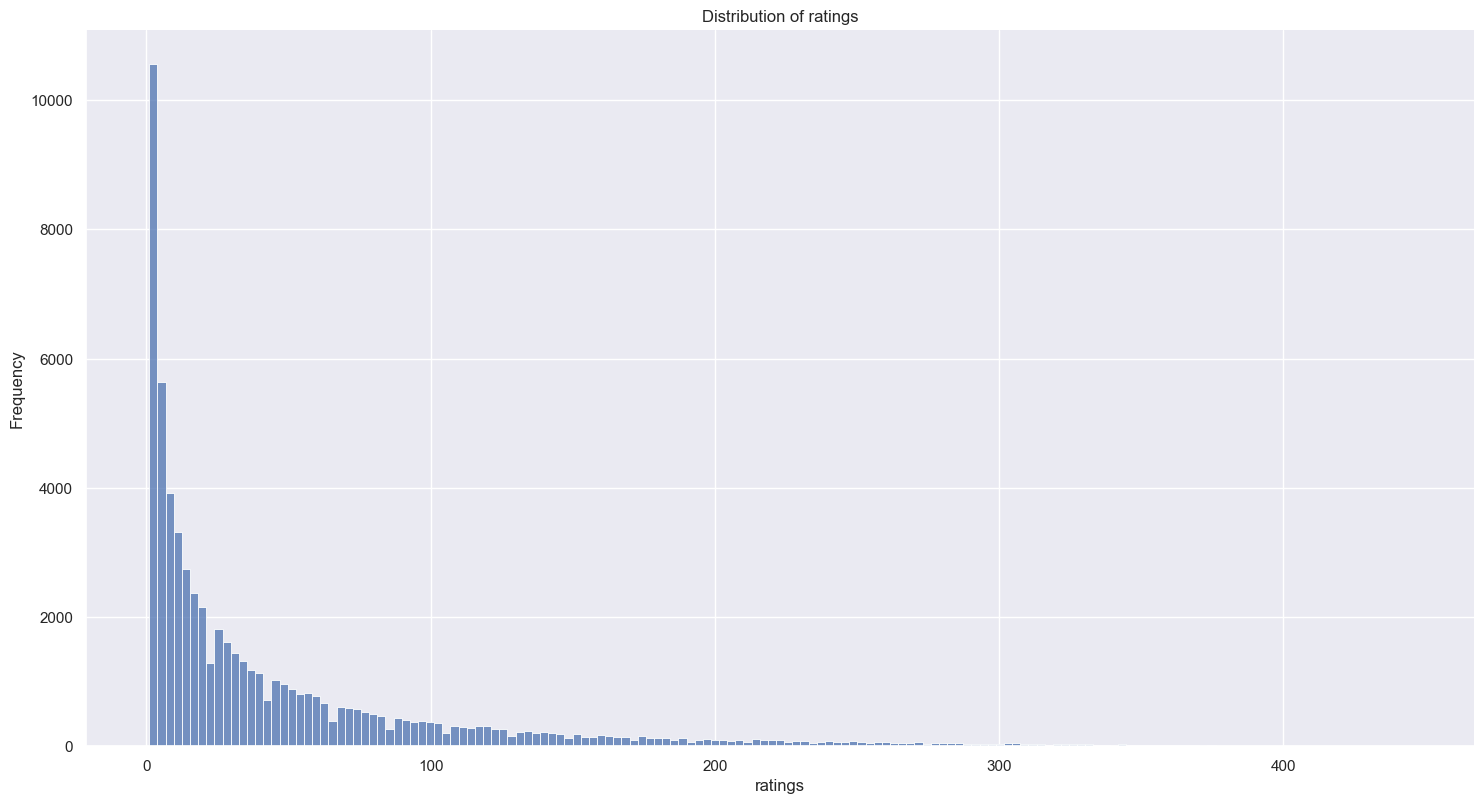

In [58]:
# Distribution of user_ratings
display_distribution(user_ratings, 'ratings')

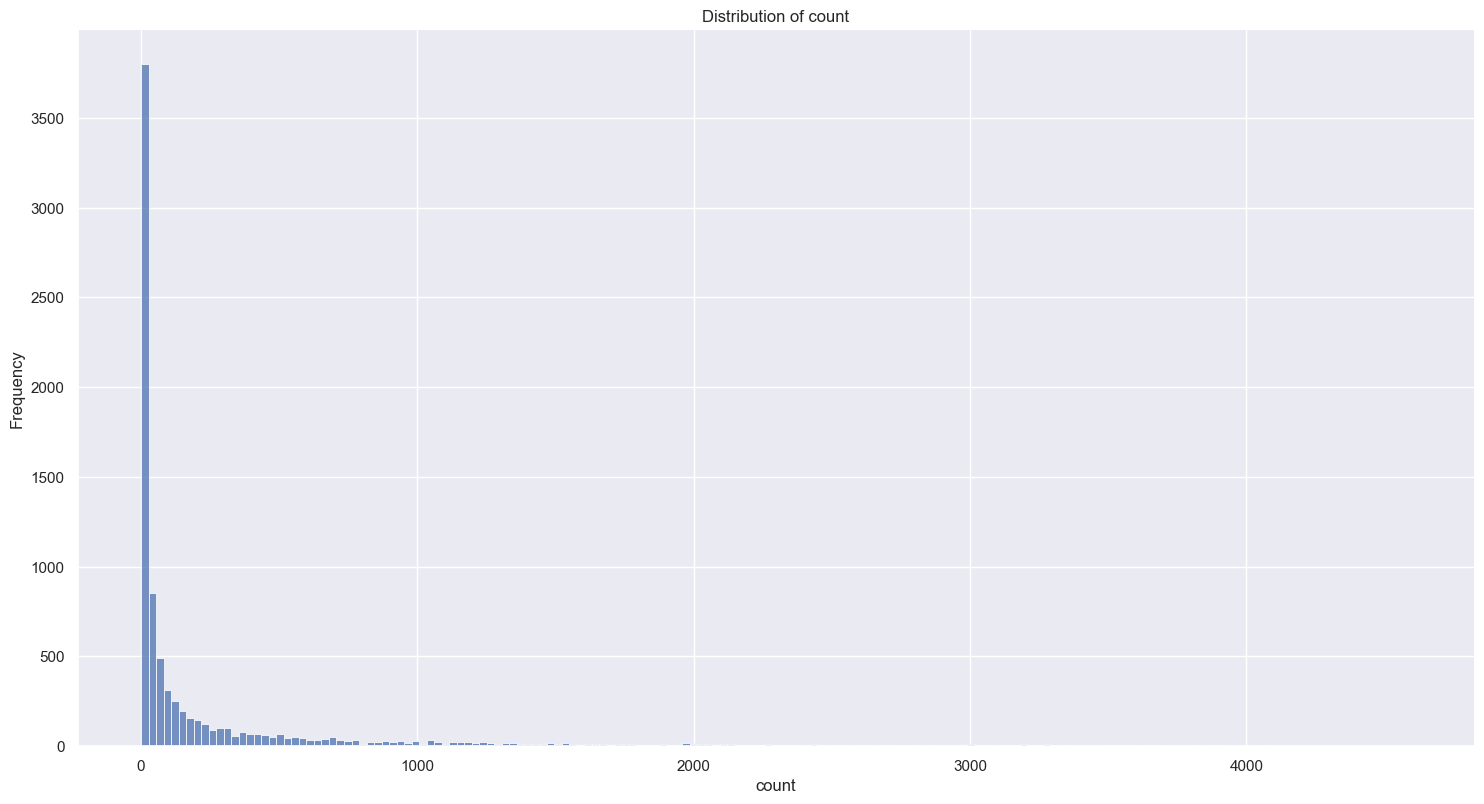

In [59]:
# Distribution of ratings_per_anime
display_distribution(ratings_per_anime, 'count')

### 3-1-3 - Conclusion for EDA in rating dataset

After performing exploratory data analysis on the rating dataset, we can conclude that the dataset has a large number of entries with a wide range of ratings, from 1 to 10. The distribution of ratings is skewed to the right with a peak at 8. We also found that the distribution of the number of user ratings per anime and the distribution of the number of ratings per user follow a similar pattern, with a steep decrease from 0 and then a more gradual decrease up to a certain threshold, where it levels off.

We further applied some pre-processing steps to the dataset, such as removing non-rated anime and users with fewer ratings, and removing outliers using a threshold approach. These steps helped to improve the quality of the data and remove noise.

# 4 - Prepare the data
In this section, we modify and prepare our data to for model building taking into account our results from part **3 - EDA**.

We do all the preprocessing that we have done in previous part in data that we did not touch, note that we copy code for a better readability: 

In [60]:
def get_user_id(predictions: list[tuple[int, int, float, int, str]]) -> int:
    """
    Get the user_id that appears most frequently in a list of predictions.

    Args:
    - predictions: A list of tuples representing predictions. Each tuple should have
        the following elements in order: user_id (int), item_id (int), real rating (float),
        predicted rating (float), and an optional fourth field (str).
    
    Returns:
    - The user_id that appears most frequently in the list of predictions.
    """
    user_counts = {}
    if len(predictions) != 0:
        for prediction in predictions:
            user_id = prediction[0]
            if user_id in user_counts:
                user_counts[user_id] += 1
            else:
                user_counts[user_id] = 1

        return max(user_counts, key=lambda x: user_counts[x])
    else:
        return 0

In [61]:
def display_top_N(
    top_N: list[tuple[str, float, int]],
    user_id: int=USER_ID,
    N: int=TOP_N
) -> None:
    """
    Prints the top N anime titles based on average rating and number of ratings.

    Args:
    - top_N (list[tuple[str, float, int]]): A list of tuples containing the top N anime titles, their average rating, and the number of ratings they have.
    - user_id (int): The number of titles to display. Defaults to TOP_N. Defaults to USER_ID.
    - N (int): The number of titles to display. Defaults to TOP_N.

    Returns:
    - None
    """
    table = PrettyTable()
    print(f"\nTop {N} for {user_id}")
    table.field_names = ["Title", "Average score", "Number of scores"]
    for title, score, num_ratings in top_N:
        table.add_row([title, score, num_ratings])
    print(table)

In [62]:
def save_model(model: object, name: str) -> None:
    """Saves a trained model to a file using pickle.

    Args:
    - model (object): A trained machine learning model object to be saved.
    - name (str): The name of the file to save the model.

    Returns:
    - None

    """
    if not os.path.exists(PKL_MODEL_DIR):
        os.makedirs(PKL_MODEL_DIR)
    with open(f"{PKL_MODEL_DIR}\\{name}.pkl", "wb") as f:
        # Using pickle to dump the model object to a binary file
        pickle.dump(model, f)


def load_model(name: str) -> object:
    """Loads a trained model from a file using pickle.

    Args:
    - name (str): The name of the file containing the saved model.

    Returns:
    - object: A trained machine learning model object.

    """
    with open(f"{PKL_MODEL_DIR}\\{name}.pkl", "rb") as f:
        # Using pickle to load the model object from the binary file
        model = pickle.load(f)
    return model

## 4-1 - Anime

In [63]:
def prepare_anime(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the anime dataset for modeling.
    
    Args:
    - df (pd.DataFrame): the anime dataset to prepare
    
    Returns:
    - pd.DataFrame: the cleaned and processed anime dataset
    """
    # Remove anime without rating
    df['rating'] = df['rating'].replace(-1, np.nan)
    # Remove rows with null values
    df = df.dropna()
    
    # Convert 'episodes' column to int
    df['episodes'] = df['episodes'].replace('Unknown', 0)
    df['episodes'] = df['episodes'].astype(int)
    
    # Replace genre by cluster
    # Replace missing values with an empty string
    df['genre'].fillna('', inplace=True)
    # Create a TfidfVectorizer object with stop words removed
    tfidf = TfidfVectorizer(stop_words='english')
    # Transform the genre column of the anime dataframe into a sparse matrix of TF-IDF features
    X = tfidf.fit_transform(df['genre'])
    # Apply K-means with NB_CLUSTER clusters
    kmeans = KMeans(n_clusters=NB_CLUSTER, random_state=0, n_init=NB_CLUSTER)
    kmeans.fit(X)
    # Retrieve cluster labels for each genre
    labels = kmeans.labels_
    # Change gere for cluster labels 
    df['genre'] = labels
    
    # Label encoded type
    label_encoder = LabelEncoder()
    df['type'] = label_encoder.fit_transform(df['type'])
    
    return df

In [64]:
anime = prepare_anime(anime_df)
warnings.simplefilter('ignore')

C:\Users\grond\AppData\Local\Temp\ipykernel_23872\2863234661.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['episodes'] = df['episodes'].replace('Unknown', 0)
C:\Users\grond\AppData\Local\Temp\ipykernel_23872\2863234661.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['episodes'] = df['episodes'].astype(int)
C:\Users\grond\AppData\Local\Temp\ipykernel_23872\2863234661.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the doc

## 4-2 - Rating

In [65]:
def prepare_rating(
    df_a: pd.DataFrame,
    df_r: pd.DataFrame,
    max_user_ratings: int=MAX_USER_RATING,
    max_ratings_per_anime: int=MAX_RATINGS_PER_ANIME
) -> pd.DataFrame:
    """
    This function prepares the ratings dataframe by removing non-ratings, 
    filtering anime that are not in the anime dataframe, and applying 
    thresholds for the number of ratings per user and anime.

    Args:
    - anime (pd.DataFrame): The anime dataframe.
    - rating (pd.DataFrame): The ratings dataframe.
    - max_user_ratings (int, optional): The maximum number of ratings per user allowed in the filtered DataFrame. Defaults to MAX_USER_RATING.
    - max_ratings_per_anime (int, optional): The maximum number of ratings per anime allowed in the filtered DataFrame. Defaults to MAX_RATINGS_PER_ANIME.

    Returns:
    - pd.DataFrame: The prepared ratings dataframe.
    """
    # Remove non rating
    df_r['rating'] = df_r['rating'].replace(-1, np.nan)
    df_r = df_r.dropna()
    
    # Remove anime that are not in the anime dataframe
    merged_df = df_a.merge(df_r, on='anime_id', how='inner')
    df_r = merged_df[['user_id', 'anime_id', 'rating_y']]
    df_r = df_r.rename(columns={'rating_y': 'rating'})
    
    # Apply thresholds for the number of ratings per user and anime
    user_counts = df_r.groupby('user_id')['rating'].count()
    user_counts = user_counts[user_counts <= max_user_ratings]
    
    anime_counts = df_r.groupby('anime_id').size()
    anime_counts = anime_counts[anime_counts <= max_ratings_per_anime]
    
    df_r = df_r[(df_r["user_id"].isin(user_counts.index)) & (df_r["anime_id"].isin(anime_counts.index))]
    return df_r

In [66]:
def get_rating_data(
    df: pd.DataFrame,
    use_minimum: bool=False
) -> tuple:
    """
    This function prepares the rating dataset for use in the Surprise library 
    by modifying the columns names, filtering users and items with a minimum number 
    of ratings if specified, creating a Surprise Reader object, and splitting the 
    raw ratings into training and validation sets.

    Args:
    - df (pd.DataFrame): The original ratings dataframe.
    - use_minimum (bool): Whether to filter users and items with a minimum number 
        of ratings. Default is False.

    Returns:
    - tuple: A tuple containing the prepared dataset, the training data, and 
        the validation data.

    """
    # Modify columns name
    df = df.rename(columns={"user_id": "user", "anime_id": "item"})
    
    if use_minimum:
        # Filter the ratings data frame to limit to users who rated a minimum number of products
        user_counts = df["user"].value_counts()
        user_counts = user_counts[user_counts >= MIN_RATING]
        df = df[df["user"].isin(user_counts.index)]
        
        # Filter the ratings data frame to limit to products that received a minimum number of ratings
        item_counts = df["item"].value_counts()
        item_counts = item_counts[item_counts >= MIN_RATING]
        df = df[df["item"].isin(item_counts.index)]
    
    # Create Reader and load data
    reader = Reader(line_format="user item rating", sep=";", skip_lines=1)
    data = Dataset.load_from_df(df, reader)
    
    # Split the raw ratings into training and validation sets
    raw_ratings = data.raw_ratings
    random.shuffle(raw_ratings)
    threshold = int(0.8 * len(raw_ratings))
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    data.raw_ratings = train_raw_ratings # data is now training set

    train_data = data.build_full_trainset().build_testset() # trainset: biased set
    test_data = data.construct_testset(test_raw_ratings) # testset: unbiased set
    return data, train_data, test_data

In [67]:
rating = prepare_rating(anime, rating_df)

In [68]:
data, train_data, test_data = get_rating_data(rating, use_minimum=WITH_MINIMUM)

In [69]:
len(train_data)

1261911

In [70]:
len(test_data)

315478

# 5 - Content-based filtering
In content-based filtering, we use the features of items (in our case, anime) to recommend similar items to users who have shown interest in a particular item. The method relies on the assumption that if a user has liked a certain item in the past, they are likely to be interested in items that share similar features. We will calculate the similarity between the item the user has shown interest in and all other items in the dataset, and recommend the most similar items to the user. 

In [71]:
def get_similarities(
    df_a: pd.DataFrame,
    df_r: pd.DataFrame,
    user_id: int=USER_ID,
    N: int=TOP_N
) -> set[tuple[str, float, int]]:
    """
    Get the top N anime recommendations for a specific user based on their past ratings.

    Args:
    - df_a (pd.DataFrame): The DataFrame containing anime metadata.
    - df_r (pd.DataFrame): The DataFrame containing anime ratings.
    - user_id (int): The ID of the user to make recommendations for. Defaults to USER_ID.
    - N (int): The number of recommendations to return. Defaults to TOP_N.

    Returns:
    - set[tuple[str, float, int]]: A set of tuples, where each tuple contains the name, rating, and number of members of an anime.

    """
    # Rename rating column to 'user_rating'
    df_r.rename(columns = {'rating':'user_rating'}, inplace = True)
    
    # Merge anime and rating dataframes on anime_id
    anime_ratings = pd.merge(df_a, df_r, on='anime_id')
    
    # Subset ratings dataframe to include only ratings made by the specific user_id
    user_ratings = anime_ratings[anime_ratings['user_id'] == user_id]
    
    # Define features to use for similarity calculation
    features = ['anime_id', 'genre', 'type', 'episodes', 'rating', 'members']
    user_features = user_ratings[features]
    anime_features = anime_ratings[features].iloc[:, :user_features.shape[1]]
    
    # Compute cosine similarity between user's preferences and all anime in dataset
    similarities = cosine_similarity(user_features, anime_features)[0]
    
    # Sort anime by similarity score and return top N recommendations
    indices = similarities.argsort()[::-1][:N]
    
    # Check that indices contain valid anime_ids
    valid_indices = []
    for index in indices:
        anime_id = anime.iloc[index]['anime_id']
        if anime_id != 0:
            valid_indices.append(index)
            
    top_n_anime = anime.iloc[valid_indices]
    anime_set = set()
    for _, row in top_n_anime.iterrows():
        anime_set.add((row['name'], row['rating'], row['members']))
        
    return anime_set

In [72]:
def get_top_N(
    anime: pd.DataFrame,
    predictions: list[tuple[int, int, float, float, dict]], 
    user_id: int=USER_ID,
    n: int=TOP_N,
    threshold: float=THRESHOLD
) -> list[tuple[str, float, int]]:
    """
    Given a pandas dataframe containing anime information, a list of predictions output by the surprise model, 
    a user ID, and optional parameters for the number of recommendations to return and the minimum threshold
    for the anime rating, returns a list of tuples containing the title, average score, and number of scores
    for the top N anime recommended for the specified user.
    
    Args:
    - anime (pd.DataFrame): A pandas dataframe containing anime information, including anime_id, name, 
        genre, type, episodes, rating, and members.
    - predictions (list[tuple[int, int, float, float, dict]]): A list of tuples output by the surprise model, 
        containing the user ID, anime ID, true rating, estimated rating, and additional details.
    - user_id (int, optional): The ID of the user for whom recommendations will be generated. Defaults to USER_ID.
    - n (int, optional): The number of recommendations to return. Defaults to TOP_N.
    - threshold (float, optional): The minimum threshold for the anime rating. Defaults to THRESHOLD.
    
    Returns:
    - list[tuple[str, float, int]]: A list of tuples containing the title, average score, and number of scores
        for the top N anime recommended for the specified user.
    """
    # Create a dictionary to store the top N recommendations for each user
    top_n = defaultdict(list)

    # Loop through each prediction in the test predictions
    for uid, iid, true_r, est, _ in predictions:
        # Store the estimated rating for this item
        top_n[uid].append((iid, est))
    
    # Loop through each user in the dictionary and sort their recommendations by estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
    # Get the top N recommendations for the specified user
    top_n_for_user = [iid for (iid, _) in top_n[user_id][:n]]
    # Get the top N recommendations for the specified user
    top_n_for_user = top_n[user_id][:n]
    top_n_for_user = [(iid, est) for (iid, est) in top_n[user_id] if anime[anime['anime_id'] == int(iid)]['rating'].values[0] >= threshold][:n]
    # Create a list of tuples containing the title, average score, and number of scores for each recommended item
    results = []
    for item_id, estimated_rating in top_n_for_user:
        item = anime[anime['anime_id'] == int(item_id)]
        title = item['name'].values[0]
        avg_score = item['rating'].values[0]
        num_scores = item['members'].values[0]
        results.append((title, avg_score, num_scores))
    
    # Return the list of recommended items with their titles, average scores, and number of scores
    return results

In [73]:
topN_Similarities = get_similarities(anime, rating)

In [74]:
display_top_N(topN_Similarities, user_id=244)


Top 10 for 244
+-----------------------------------------+---------------+------------------+
|                  Title                  | Average score | Number of scores |
+-----------------------------------------+---------------+------------------+
|                 Kuruneko                |      7.63     |       2526       |
|              Kimi no Na wa.             |      9.37     |      200630      |
|  Hokuto no Ken: Raoh Gaiden Gekitou-hen |      7.63     |       4614       |
|          Initial D Battle Stage         |      7.63     |      13633       |
|      Angel Beats!: Another Epilogue     |      7.63     |      134180      |
|           Hakuouki Reimeiroku           |      7.63     |      29485       |
|   Konnichiwa Anne: Before Green Gables  |      7.63     |       2723       |
|          Love Live! Sunshine!!          |      7.63     |      45246       |
|                Shigofumi                |      7.62     |      54000       |
| Mardock Scramble: The First Compre

# 6 - Collaborative filtering

Collaborative filtering is a technique used in recommender systems to make personalized recommendations for users based on their past interactions with items and the interactions of similar users. This approach is based on the assumption that users who have similar preferences in the past are likely to have similar preferences in the future. Collaborative filtering can be done in two ways: user-based and item-based. In user-based collaborative filtering, recommendations are made based on the preferences of similar users, while in item-based collaborative filtering, recommendations are made based on the similarity between items. 

In [75]:
def get_benchmark(
    data: Dataset, 
    lOO: bool = False
) -> pd.DataFrame:
    """
    Generates a benchmark DataFrame for a set of Surprise recommendation algorithms.

    Args:
    - data: A Surprise Dataset object containing the ratings data to use for training and testing.
    - lOO (bool): A boolean to configure the used of LeaveOneOut.

    Returns:
    - A pandas DataFrame containing the RMSE scores for each algorithm, along with their names.
    """
    
    experiment_full_name = f"{EXPERIMENT}_benchmark_loo.csv" if lOO else f"{EXPERIMENT}_benchmark.csv"
    cv = LeaveOneOut() if lOO else 5
    
    if os.path.exists(os.path.join(DATA_DIR, experiment_full_name)):
        # Load pre-existing benchmark DataFrame from CSV file
        with open(f"{EXPERIMENT}_benchmark.csv", "rb") as f:
            benchmark_df = load_csv(os.path.join(DATA_DIR, experiment_full_name))
            return benchmark_df
    else:
        benchmark = []
        # Iterate over all algorithms
        for algorithm in [NormalPredictor(), BaselineOnly(), SVD(), SVDpp(), SlopeOne(), CoClustering()]: #, KNNBasic(), KNNWithMeans(), KNNWithZScore(), KNNBaseline(),
            # Perform cross validation
            results = cross_validate(algorithm, data, measures=['RMSE'], cv=cv, verbose=False)

            # Get results & append algorithm name
            tmp = pd.DataFrame.from_dict(results).mean(axis=0)
            tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
            benchmark.append(tmp)
        benchmark_df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    
        
        # Save benchmark DataFrame to CSV file
        benchmark_df.to_csv(os.path.join(DATA_DIR, experiment_full_name), index = True)
        return benchmark_df

In [76]:
def get_hyperparams(
    trial: optuna.Trial,
    hyperparams_dict: object
) -> object:
    """
    Generate hyperparameters for Surprise model using Optuna.

    Args:
    - trial (optuna.Trial): The optuna trial object.
    - hyperparams_dict (dict): A dictionary containing the hyperparameters to optimize.

    Returns:
    - dict: A dictionary containing the optimized hyperparameters for the Surprise model.

    Raises:
    - ValueError: If the hyperparameter type is invalid.

    """
    hyperparams = {}
    for param, values in hyperparams_dict.items():
        if param == "bsl_options":
            hyperparams["bsl_options"] = {
                "method" : trial.suggest_categorical("method", ["als", "sgd"]),
                "n_epochs" : trial.suggest_int("n_epochs", 5, 20),
                "reg_u" : trial.suggest_float("reg_u", 5, 10),
                "reg_i" : trial.suggest_float("reg_i", 5, 10)
            }
        elif param == "sim_options":
            hyperparams["sim_options"] = {
                "name" : trial.suggest_categorical("name", ['cosine', 'msd', 'pearson']),
                "user_based" : True if trial.suggest_categorical("user_based", [True, False]) else False,
                "min_support" : trial.suggest_float("min_support", 1, 20)
            }
        elif values[0] == 'categorical':
            if param == 'user_based':
                hyperparams[param] = True if trial.suggest_categorical(param, [True, False]) else False
            else:
                hyperparams[param] = trial.suggest_categorical(param, values[1])
        elif values[0] == 'int':
            hyperparams[param] = trial.suggest_int(param, values[1], values[2])
        elif values[0] == 'uniform':
            hyperparams[param] = trial.suggest_uniform(param, values[1], values[2])
        elif values[0] == 'loguniform':
            hyperparams[param] = trial.suggest_loguniform(param, values[1], values[2])
        else:
            raise ValueError(f"Invalid parameter type: {values[0]}")
    return hyperparams

In [77]:
def objective(
    trial: any, 
    data: Dataset, 
    model: any,
    hyperparams: object,
    cv: int=5, 
    verbose: bool=False
) -> float:
    """
    Optimize a model with hyperparameters using cross-validation, log the results with mlflow, and return the 
    minimum RMSE value.
    
    Args:
    - trial: An object representing a single trial of an experiment with a hyperopt optimization algorithm.
    - data: A Surprise Dataset object containing the ratings data to use for training and testing.
    - model: A Surprise algorithm instance to use for training and testing.
    - hyperparams: A dictionary containing hyperparameters to optimize over.
    - cv: An optional integer indicating the number of cross-validation folds to use.
    - verbose: An optional boolean indicating whether to print out progress information during cross-validation.
    
    Returns:
    - A float representing the minimum RMSE value achieved during cross-validation.
    """
    # Use hyperopt, an Distributed Hyperparameter Optimization, to get the hyperparameters to use for the current trial
    options = get_hyperparams(trial, hyperparams) 
    # Use the selected hyperparameters to instantiate a new model object
    if options:
        model_instance = model(**options)
    else:
        model_instance = model()

    # Evaluate the model with cross-validation using the Surprise library
    results = cross_validate(model_instance, data, measures=['rmse'], cv=cv, verbose=verbose)
    # Get the minimum RMSE score from the cross-validation results
    rmse = results['test_rmse'].min()
    
    # Return the minimum RMSE value as the objective value for this trial
    return rmse

In [78]:
def fit_model(
    data: Dataset,
    name: str,
    model: any,
    hyperparams_dict: object=None,
    bsl_options: bool=False
) -> object:
    """
    Fit a surprise model with the given dataset and hyperparameters using either
    Optuna hyperparameter search or a default parameter setting.
    
    Args:
    - data (Dataset): Surprise dataset to use for training and evaluation.
    - name (str): A name to identify the model in the experiment.
    - model (any): The surprise model to use for training.
    - hyperparams_dict (object): Dictionary containing hyperparameters
      to be optimized with Optuna. If None, the default hyperparameters will be used.
    - bsl_options (bool): Whether to optimize hyperparameters for the SVD baseline algorithm.
      Default is False.
    
    Returns:
    - object: A dictionary containing the trained model, best hyperparameters
      (if hyperparams_dict is not None), and the RMSE score of the best model.
    """
    EXPERIMENT_NAME = f"{EXPERIMENT}-{name}"
    if os.path.exists(f"{PKL_MODEL_DIR}\\{EXPERIMENT_NAME}.pkl"):
        with open(f"{PKL_MODEL_DIR}\\{EXPERIMENT_NAME}.pkl", "rb") as f:
            model = pickle.load(f)
            return model
    else:
        print(f"Model {name} not exist yet.")
        # Set up the experiment
        mlflow.set_experiment(EXPERIMENT_NAME)

        # Fit the model
        with mlflow.start_run(run_name="fit_model", nested=True) as run:
            run_id = run.info.run_id
            if hyperparams_dict is None:
                # Train the model using default hyperparameters
                best_model = model().fit(data.build_full_trainset()) # fit on the whole train data set
                
                # Register model locally in pickle file
                save_model({'model': best_model}, EXPERIMENT_NAME)

                # Log model and experiment parameters
                mlflow.sklearn.log_model(best_model, "models")
                mlflow.register_model(f"runs:/{run_id}/models", EXPERIMENT_NAME)
                # mlflow.log_param('MAX_USER_RATING', MAX_USER_RATING)
                # mlflow.log_param('MAX_RATINGS_PER_ANIME', MAX_RATINGS_PER_ANIME)
                # mlflow.log_param('MIN_RATING', MIN_RATING)
                # Stage the model in production
                client.transition_model_version_stage(
                    name=EXPERIMENT_NAME, version=1, stage="Production"
                )

                # Return the trained model
                return {'model': best_model}
            else:
                # Set up Optuna study
                study = optuna.create_study(
                    storage=OPTUNA_DB,  
                    study_name=name,
                    pruner=optuna.pruners.PatientPruner(None, patience=PATIENCE),
                    direction='minimize',
                    load_if_exists=True)

                # Run the hyperparameter search
                study.optimize(lambda trial: objective(trial, data, model, hyperparams_dict), n_trials=N_TRIAL)

                # Get the best hyperparameters and the best score
                best_hyperparameters = study.best_params
                if bsl_options:
                    best_hyperparameters = {'bsl_options': {'method': best_hyperparameters['method'], 
                                                        'n_epochs': best_hyperparameters['n_epochs'], 
                                                        'reg_i': best_hyperparameters['reg_i'], 
                                                        'reg_u': best_hyperparameters['reg_u']}}
                fit_rmse = study.best_value
                best_model = model(**best_hyperparameters)

                # Fit the model with the best hyperparameters
                best_model.fit(data.build_full_trainset()) # fit on the whole train data set

                # Register model locally in pickle file
                save_model({'model': best_model, 'hyperparameters': best_hyperparameters, 'fit_rmse': fit_rmse}, EXPERIMENT_NAME)

                mlflow.sklearn.log_model(best_model, "models")
                # Register the model with mlflow
                mlflow.register_model(f"runs:/{run_id}/models", EXPERIMENT_NAME)
                # Log the model parameters and performance metrics with mlflow
                mlflow.log_params(best_hyperparameters)
                # mlflow.log_param('MAX_USER_RATING', MAX_USER_RATING)
                # mlflow.log_param('MAX_RATINGS_PER_ANIME', MAX_RATINGS_PER_ANIME)
                # mlflow.log_param('MIN_RATING', MIN_RATING)
                mlflow.log_metric("rmse", fit_rmse)
                # Stage the model in production
                client.transition_model_version_stage(
                    name=EXPERIMENT_NAME, version=1, stage="Production"
                )

                # Return the best model with the best hyperparameters and the score
                return {'model': best_model, 'hyperparameters': best_hyperparameters, 'fit_rmse': fit_rmse}

In [79]:
def calculate_metrics(
    predictions: list[tuple[int, int, float, float, any]],
    data: list[tuple[int, int, float]],
    threshold: float
) -> object:
    """
    Calculate various evaluation metrics for a given set of predictions.

    Args:
    - predictions (list[tuple[int, int, float, float, any]]): A list of tuples containing the user id, item id, true rating, estimated rating, and additional information (if any) for each prediction.
    - data (list[tuple[int, int, float]]): A list of tuples containing the user id, item id, and rating for each data point.
    - threshold (float): The threshold above which a rating is considered positive.

    Returns:
    - metrics (object): A dictionary containing the evaluation metrics.
    """
    # User coverage
    recommended_users = set()
    n_users = len(set([t[0] for t in data]))
    for uid, iid, true_r, est, _ in predictions:
        recommended_users.add(uid)

    # Initialize a dictionary to store the evaluation results
    metrics = defaultdict(float)

    # Define y_true and y_pred
    y_true = [true_r for uid, iid, true_r, est, _ in predictions]
    y_pred = [est if est >= threshold else threshold for uid, iid, true_r, est, _ in predictions]

    # Calculate various evaluation metrics
    metrics['hit_rate'] = len(set(y_true) & set(y_pred)) /  len(set(y_true)) if len(set(y_true)) != 0 else 1
    metrics['mae'] = accuracy.mae(predictions)
    metrics['rmse'] = accuracy.rmse(predictions)
    metrics['user_coverage'] = len(recommended_users) / n_users if n_users != 0 else 0

    return metrics

In [80]:
def evaluate_model(
    name: str,
    model: any,
    trainset: list,
    testset: list,
    threshold: float=THRESHOLD
) -> object:
    """
    Evaluates a model on a given dataset and returns the evaluation metrics and predictions.

    Args:
    - name (str): The name of the model.
    - model (Trainset): The model to be evaluated.
    - trainset (list): The dataset to be used for biased evaluation.
    - testset (list): The dataset to be used for unbiased evaluation.
    - threshold (float): The threshold above which a rating is considered positive. Defaults to THRESHOLD.

    Returns:
    - dict: A dictionary containing the evaluation metrics and the predictions.
    """
    try:
        with mlflow.start_run(run_name="evaluate_model", nested=True) as run:
            run_id = run.info.run_id
            EXPERIMENT_NAME = f"{EXPERIMENT}-{name}"
            mlflow.set_experiment(EXPERIMENT_NAME)

            # Compute biased and unbiased predictions
            biased_predictions = model.test(trainset)
            unbiased_predictions = model.test(testset)

            # Calculate evaluation metrics for biased and unbiased predictions
            biased_metrics = calculate_metrics(biased_predictions, trainset, threshold)
            unbiased_metrics = calculate_metrics(unbiased_predictions, testset, threshold)

            # Log the model and the evaluation metrics to MLflow
            mlflow.sklearn.log_model(model, "models")
            mlflow.register_model(f"runs:/{run_id}/models", EXPERIMENT_NAME)

            for metric, value in biased_metrics.items():
                mlflow.log_metric(f'biased_{metric}', value)
            for metric, value in unbiased_metrics.items():
                mlflow.log_metric(f'unbiased{metric}', value)

            # Create a PrettyTable for displaying the evaluation metrics
            table = PrettyTable()
            table.field_names = ["Metric", "Value"]
            for metric, value in biased_metrics.items():
                table.add_row([f'biased_{metric}', f'{value:.2f}'])
            for metric, value in unbiased_metrics.items():
                table.add_row([f'unbiased_{metric}', f'{value:.2f}'])
            print(table)

            return {'biased_metrics': biased_metrics, 'unbiased_metrics': unbiased_metrics, 'unbiased_predictions': unbiased_predictions, 'biased_predictions': biased_predictions}
    except Exception as e:
        print(e)
        return None

In [81]:
def get_top_N(
    anime: pd.DataFrame,
    predictions: list[tuple],
    user_id: int=USER_ID,
    n: int=TOP_N,
    threshold: float=THRESHOLD
) -> list[tuple[str, float, int]]:
    """
    Given a DataFrame of anime, a list of predictions, a user ID, and optional parameters for the number of recommendations
    to generate and the rating threshold, returns a list of top N anime recommendations for the specified user, along with 
    each recommended item's title, average score, and number of scores.
    
    Args:
    - anime: A DataFrame of anime data, including anime IDs, titles, ratings, and member counts.
    - predictions: A list of tuples representing predicted ratings for each user-item pair in the test set, in the format
                 (user_id, item_id, true_rating, estimated_rating, _).
    - user_id: An integer representing the user ID for which to generate recommendations. Defaults to USE_ID.
    - n: An integer representing the number of recommendations to generate for the specified user. Defaults to TOP_N.
    - threshold: A float representing the minimum rating threshold for recommended items. Defaults to THRESHOLD.
    
    Returns:
        A list of tuples representing the top N recommended anime for the specified user, each in the format 
        (title, average_score, num_scores).
    """
    # Create a dictionary to store the top N recommendations for each user
    top_n = defaultdict(list)

    # Loop through each prediction in the test predictions
    for uid, iid, true_r, est, _ in predictions:
        # Store the estimated rating for this item
        top_n[uid].append((iid, est))
    # Loop through each user in the dictionary and sort their recommendations by estimated rating
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        
    # Get the top N recommendations for the specified user
    top_n_for_user = [(iid, est) for (iid, est) in top_n[user_id] if anime[anime['anime_id'] == int(iid)]['rating'].values[0] >= threshold][:n]

    # Create a list of tuples containing the title, average score, and number of scores for each recommended item
    results = []
    for item_id, estimated_rating in top_n_for_user:
        item = anime[anime['anime_id'] == int(item_id)]
        title = item['name'].values[0]
        avg_score = item['rating'].values[0]
        num_scores = item['members'].values[0]
        results.append((title, avg_score, num_scores))
    
    # Return the list of recommended items with their titles, average scores, and number of scores
    return results

### 6-0 - Overview

In [82]:
# Uncomment to create benchmark
# benchmark_df = get_benchmark(data)

In [83]:
benchmark_w_minimum = load_csv(BENCHMARK_W_MINIMUM)
benchmark_w_minimum

,Algorithm,test_rmse,fit_time,test_time
0,SVD,3.000908,11.345545,4.569087
1,SVDpp,3.001033,86.706086,47.654577
2,CoClustering,3.001159,21.882150,3.881786
3,KNNBaseline,3.001356,29.073506,155.477129
4,KNNWithMeans,3.001358,25.657233,144.901536
5,KNNWithZScore,3.001401,26.755400,149.358888
6,SlopeOne,3.001408,5.315811,33.581455
7,BaselineOnly,3.001858,2.074583,2.598070
8,KNNBasic,3.002762,25.687444,150.441401
9,NormalPredictor,3.034947,1.370998,2.531927


In [84]:
benchmark_wo_minimum = load_csv(BENCHMARK_WO_MINIMUM)
benchmark_wo_minimum

,Algorithm,test_rmse,fit_time,test_time
0,SVD,3.083794,28.245734,12.273581
1,SVDpp,3.084290,161.740540,91.111157
2,SlopeOne,3.084531,10.901521,65.313976
3,BaselineOnly,3.084580,5.726482,9.207652
4,CoClustering,3.084990,59.023124,13.315203
5,NormalPredictor,3.118191,3.606412,9.149063


Based on our benchmark dataframe, we can conclude that using a threshold for a minimum value for rating per anime and number of rating by users is more effective in improving model performance.

For the choice of algorithms to use, we recommend the following:

- SVD: the fastest and most effective algorithm in our tests
- CoClustering: relatively fast and the third most effective algorithm
- SlopeOne: relatively fast, but not necessarily needed given its lower rank
- BaselineOnly: very fast and can be kept as a comparison model
- NormalPredictor: very fast and does not require hyperparameter tuning, making it a good option to keep as a comparison model

We found that the following algorithms were too slow and not as effective, and thus do not recommend using them:

- SVDpp
- KNNBaseline
- KNNWithMeans
- KNNWithZScore
- KNNBasic

Overall, our results suggest that a combination of the thresholding approach with the recommended algorithms can lead to improved model performance in collaborative filtering tasks.

### 6-1 - Comparison models

#### 6-1-1 - Random model Algorithm 
This algorithm is the most basic collaborative filtering algorithm. It recommends anime titles to users randomly, without taking into account any user preferences or feedback. The accuracy of this algorithm is extremely low, but it provides a useful baseline for comparison with other algorithms.

In [85]:
best_NormalPredictor = fit_model(data, 'NormalPredictor', NormalPredictor)

In [86]:
predictions_NormalPredictor = evaluate_model('NormalPredictor', best_NormalPredictor['model'], train_data, test_data, threshold=0)

MAE:  2.7186
RMSE: 3.0354
MAE:  2.7220
RMSE: 3.0395


Registered model 'test_w_min_rating-NormalPredictor' already exists. Creating a new version of this model...
2023/03/25 17:55:41 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: test_w_min_rating-NormalPredictor, version 10


+------------------------+-------+
|         Metric         | Value |
+------------------------+-------+
|    biased_hit_rate     |  0.20 |
|       biased_mae       |  2.72 |
|      biased_rmse       |  3.04 |
|  biased_user_coverage  |  1.00 |
|   unbiased_hit_rate    |  0.10 |
|      unbiased_mae      |  2.72 |
|     unbiased_rmse      |  3.04 |
| unbiased_user_coverage |  1.00 |
+------------------------+-------+


Created version '10' of model 'test_w_min_rating-NormalPredictor'.


In [87]:
topN_NormalPredictor = get_top_N(anime, predictions_NormalPredictor['unbiased_predictions'], user_id=get_user_id(predictions_NormalPredictor['unbiased_predictions']))
display_top_N(topN_NormalPredictor, USER_ID)


Top 10 for 244
+------------------------------------------------------------+---------------+------------------+
|                           Title                            | Average score | Number of scores |
+------------------------------------------------------------+---------------+------------------+
|                         Shigofumi                          |      7.62     |      54000       |
|                  Umineko no Naku Koro ni                   |      7.34     |      126865      |
|                 Another: The Other - Inga                  |      7.5      |      86261       |
|   Gate: Jieitai Kanochi nite, Kaku Tatakaeri 2nd Season    |      7.97     |      153501      |
|                     Hellsing: The Dawn                     |      7.37     |      40548       |
|                         Inaka Isha                         |      6.88     |      10030       |
|                        Love Stage!!                        |      7.69     |      83397       |
| Ma

#### 6-1-2 - Baseline only Algorithm 
This algorithm is a simple collaborative filtering algorithm that uses a baseline estimate to predict user ratings for anime titles. The baseline estimate is based on the average rating for each anime title and the average rating for each user. The algorithm then adjusts these estimates based on the user's deviations from their average rating and the anime title's deviations from its average rating. This algorithm performs better than the random model algorithm, but is still quite basic.

In [88]:
hyper_BaselineOnly = {
    "bsl_options": 0
}

In [89]:
best_BaselineOnly = fit_model(data, 'BaselineOnly', BaselineOnly, hyper_BaselineOnly, bsl_options=True)

In [90]:
predictions_BaselineOnly = evaluate_model('BaselineOnly', best_BaselineOnly['model'], train_data, test_data, threshold=0)

MAE:  2.6874
RMSE: 3.0014
MAE:  2.6905
RMSE: 3.0054


Registered model 'test_w_min_rating-BaselineOnly' already exists. Creating a new version of this model...
2023/03/25 17:55:55 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: test_w_min_rating-BaselineOnly, version 10


+------------------------+-------+
|         Metric         | Value |
+------------------------+-------+
|    biased_hit_rate     |  0.20 |
|       biased_mae       |  2.69 |
|      biased_rmse       |  3.00 |
|  biased_user_coverage  |  1.00 |
|   unbiased_hit_rate    |  0.20 |
|      unbiased_mae      |  2.69 |
|     unbiased_rmse      |  3.01 |
| unbiased_user_coverage |  1.00 |
+------------------------+-------+


Created version '10' of model 'test_w_min_rating-BaselineOnly'.


In [91]:
topN_BaselineOnly = get_top_N(anime, predictions_BaselineOnly['unbiased_predictions'], user_id=get_user_id(predictions_BaselineOnly['unbiased_predictions']))
display_top_N(topN_BaselineOnly)


Top 10 for 244
+------------------------------------------------------------+---------------+------------------+
|                           Title                            | Average score | Number of scores |
+------------------------------------------------------------+---------------+------------------+
|                           DearS                            |      6.8      |      91037       |
|                         Shigofumi                          |      7.62     |      54000       |
|                  Umineko no Naku Koro ni                   |      7.34     |      126865      |
|                 Another: The Other - Inga                  |      7.5      |      86261       |
|   Gate: Jieitai Kanochi nite, Kaku Tatakaeri 2nd Season    |      7.97     |      153501      |
|                     Hellsing: The Dawn                     |      7.37     |      40548       |
|                         Inaka Isha                         |      6.88     |      10030       |
|   

In [100]:
topN_BaselineOnly

[('DearS', 6.8, 91037),
 ('Shigofumi', 7.62, 54000),
 ('Umineko no Naku Koro ni', 7.34, 126865),
 ('Another: The Other - Inga', 7.5, 86261),
 ('Gate: Jieitai Kanochi nite, Kaku Tatakaeri 2nd Season', 7.97, 153501),
 ('Hellsing: The Dawn', 7.37, 40548),
 ('Inaka Isha', 6.88, 10030),
 ('Love Stage!!', 7.69, 83397),
 ('Mahou Shoujo Madoka★Magica Movie 3: Hangyaku no Monogatari', 8.5, 135735),
 ('Mitsudomoe', 7.73, 56483)]

### 6-2 - KNN Algorithms
These algorithms uses the k-nearest neighbors approach to collaborative filtering. It computes the similarities between users or items and selects the k most similar neighbors to make predictions. The algorithm can use different similarity metrics, such as cosine similarity or Pearson correlation, to compute similarities between users or items. The KNN algorithm typically performs better than the random model and baseline only algorithms.

In [92]:
def display_knn(predictions: object) -> None:
    """Visualize the predicted vs. actual ratings for the k-NN model using a scatter plot.

    Args:
    - predictions (dict): A dictionary containing the k-NN model predictions and metrics.

    Returns:
    - None.
    """
    # Extract the predicted and actual ratings for each user-item pair
    y_pred = [pred[3] for pred in predictions['predictions']]
    y_true = [pred[2] for pred in predictions['predictions']]
    rmse = predictions['metrics']['mae']
    
    # Create a scatter plot to visualize the predicted vs. actual ratings
    sns.regplot(x=y_true, y=y_pred, scatter_kws={'alpha': 0.5})
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.ylim(0, 10)
    plt.title(f'k-NN Model Performance (RMSE = {rmse:.3f})')
    plt.show()

#### 6-2-1 - KNNBasic
This is the basic version of KNN, which predicts a rating by taking a weighted average of the ratings of K nearest neighbors to the user-item pair being predicted. The weights are calculated based on the similarity between the users/items.

In [93]:
# Uncomment to test KNNBasic
# hyper_KNNBasic = {
#     "name": ["categorical", ["pearson"]],
#     "user_based": ["categorical", 0],
#     "k": ["int", 20, 40],
#     "min_k": ["int", 1, 10],
# }
# best_KNNBasic = fit_model(data, 'KNNBasic', KNNBasic, hyper_KNNBasic)
# predictions_KNNBasic = evaluate_model('KNNBasic', best_KNNBasic['model'], train_data, test_data, threshold=0)
# topN_KNNBasic = get_top_N(anime, predictions_KNNBasic['predictions'], user_id=get_user_id(predictions_KNNBasic['predictions']))
# display_top_N(topN_KNNBasic)

#### 6-2-2 - KNNWithMeans 
This variant of KNN is similar to KNNBasic, but it takes into account the mean rating of each user/item when calculating the similarity between them. This is done to account for user/item biases in the data.

In [94]:
# Uncomment to test KNNBasic
# hyper_KNNWithMeans = {
#     "name": ["categorical", ["pearson"]],
#     "user_based": ["categorical", _],
#     "min_support": ["int", 1, 2],
#     "k": ["int", 20, 40],
#     "min_k": ["int", 1, 10],
# }
# best_KNNWithMeans = fit_model(data, 'KNNWithMeans', KNNWithMeans, hyper_KNNWithMeans)
# predictions_KNNWithMeans = evaluate_model('KNNWithMeans', best_KNNWithMeans['model'], train_data, test_data)
# topN_KNNWithMeans = get_top_N(anime, predictions_KNNWithMeans['predictions'], user_id=get_user_id(predictions_KNNWithMeans['predictions']))
# display_top_N(topN_KNNWithMeans)

#### 6-2-3 - KNNWithZScore 
This is another variant of KNN that takes into account the mean and standard deviation of each user/item when calculating the similarity between them. This is done to normalize the data and account for the scale differences between users/items.

In [95]:
# Uncomment to test KNNWithZScore
# hyper_KNNWithZScore = {
#     "name": ["categorical", ['cosine', 'msd', 'pearson']],
#     "user_based": ["categorical", 'user'],
#     "min_support": ["int", 1, 20],
#     "k": ["int", 20, 40],
#     "min_k": ["int", 1, 10],
# }
# best_KNNWithZScore = fit_model(data, 'KNNWithZScore', KNNWithZScore, hyper_KNNWithZScore)
# predictions_KNNWithZScore = evaluate_model('KNNWithZScore', best_KNNWithZScore['model'], train_data, test_data)
# topN_KNNWithZScore = get_top_N(anime, predictions_KNNWithZScore['predictions'], user_id=get_user_id(predictions_KNNWithZScore['predictions']))
# display_top_N(topN_KNNWithZScore)

#### 6-2-4 - KNNBaseline
This variant of KNN incorporates a baseline estimate of the ratings into the calculation of the similarity between users/items. The baseline estimate is calculated based on the global mean rating, the mean rating of each user, and the mean rating of each item. This helps to account for the different rating scales and biases in the data.

In [96]:
# hyper_KNNBaseline = {
#     "sim_options": 0,
#     "k": ["int", 20, 40],
#     "min_k": ["int", 1, 10],
#     "bsl_options": 0,
# }
# best_KNNBaseline = fit_model(data, 'KNNBaseline', KNNBaseline, hyper_KNNBaseline)
# predictions_KNNBaseline = evaluate_model('KNNBaseline', best_KNNBaseline['model'], train_data, test_data)
# topN_KNNBaseline = get_top_N(anime, predictions_KNNBaseline['predictions'], user_id=get_user_id(predictions_KNNBaseline['predictions']))
# display_top_N(topN_KNNBaseline)

###  6-3 - Matrix factorization
These algorithms uses matrix factorization techniques to decompose the user-item matrix into lower-dimensional matrices that capture latent features of users and items. The algorithm then uses these matrices to predict user ratings for anime titles. 

#### 6-3-1 - SVD
SVD, or Singular Value Decomposition, is a matrix factorization method used to reduce the dimensionality of a matrix while preserving the most important information in it.
In simpler terms, SVD helps us find the underlying patterns and relationships between the rows and columns of a matrix. This allows us to extract the most important features of the original data and represent it in a lower-dimensional space. 

In [97]:
hyper_SVD = {
    "n_factors": ["int", 50, 200],
    "n_epochs": ["int", 10, 50],
    "lr_all": ["loguniform", 1e-4, 1e-1],
    "reg_all": ["loguniform", 1e-4, 1e-1],
}

In [98]:
best_SVD = fit_model(data, 'SVD', SVD, hyper_SVD)

In [99]:
predictions_SVD = evaluate_model('SVD', best_SVD['model'], train_data, test_data)

MAE:  2.6874
RMSE: 3.0014


KeyboardInterrupt: 

In [ ]:
topN_SVD = get_top_N(anime, predictions_SVD['unbiased_predictions'], user_id=get_user_id(predictions_SVD['unbiased_predictions']))
display_top_N(topN_SVD)

#### 6-3-2 - SVDpp
SVD++, or SVD with implicit feedback, is an extension of SVD that incorporates additional information about user-item interactions, such as how frequently a user has interacted with an item. 

In [ ]:
# Uncomment to test SVDpp
# hyper_SVDpp = {
#     "n_factors": ["int", 50, 200],
#     "n_epochs": ["int", 10, 50],
#     "lr_all": ["loguniform", 1e-5, 1e-1],
#     "reg_all": ["loguniform", 1e-5, 1e-1]
# }
# best_SVDpp = fit_model(data, 'SVDpp', SVDpp, hyper_SVDpp)
# predictions_SVDpp = evaluate_model('SVDpp', best_SVDpp['model'], train_data, test_data)
# topN_SVDpp = get_top_N(anime, predictions_SVDpp['predictions'], user_id=get_user_id(predictions_SVDpp['predictions']))
# display_top_N(topN_SVDpp)

###  6-4 - Other algorithms
This section of the notebook explores other types of collaborative filtering algorithms.

#### 6-4-1 - Slope One
Slope One is a simple collaborative filtering algorithm that uses the difference between item ratings to predict user preferences. It computes the average difference in ratings between pairs of items that have been rated by the same user, and then uses these differences to estimate the missing ratings. This method is fast and scalable, making it a popular choice for recommendation systems.

In [ ]:
best_SlopeOne = fit_model(data, 'SlopeOne', SlopeOne)

In [ ]:
predictions_SlopeOne = evaluate_model('SlopeOne', best_SlopeOne['model'], train_data, test_data)

In [ ]:
topN_SlopeOne = get_top_N(anime, predictions_SlopeOne['unbiased_predictions'], user_id=get_user_id(predictions_SlopeOne['unbiased_predictions']))
display_top_N(topN_SlopeOne)

#### 6-4-2 - CoClustering
CoClustering is a clustering-based collaborative filtering algorithm that groups users and items based on their similarities in ratings. It performs simultaneous clustering of both users and items to identify groups of users who have similar preferences and groups of items that are preferred by similar users. CoClustering works well with sparse data and can effectively capture complex user-item relationships. However, it can be computationally expensive and may not scale well for large datasets.

In [ ]:
hyper_CoClustering = {
    "n_cltr_u": ["int", 3, 20],
    "n_cltr_i": ["int", 3, 20],
    "n_epochs": ["int", 10, 50],
    "random_state": ["int", 0, 100],
}

In [ ]:
best_CoClustering = fit_model(data, 'CoClustering', CoClustering, hyper_CoClustering)

In [ ]:
predictions_CoClustering = evaluate_model('CoClustering', best_CoClustering['model'], train_data, test_data)

In [ ]:
topN_CoClustering = get_top_N(anime, predictions_CoClustering['unbiased_predictions'], user_id=get_user_id(predictions_CoClustering['unbiased_predictions']))
display_top_N(topN_CoClustering)

# 7 - Test on our data
Finally we tested our collaborative filtering model on our custom-made dataset. We used the model with the best unbiased RMSE : CoClustering. There is still room for improvement, and further experimentation and tuning could lead to even better results. Overall, this project demonstrated the power of collaborative filtering in generating personalized recommendations based on user behavior, and highlighted some of the key challenges and considerations involved in building and evaluating such models.

In [ ]:
def create_our_dataframe(anime: pd.DataFrame) -> pd.DataFrame:
    """
    Create a DataFrame for our test data containing ratings for selected anime titles.
    
    Args:
    - anime: a Pandas DataFrame containing the anime data
    
    Returns:
    - our_df: a Pandas DataFrame containing the test data for our selected anime titles
    """
    # Filter the anime DataFrame to only include our selected titles
    our_anime_id = anime['anime_id'][:500]
    # Filter the anime DataFrame to only include our selected titles
    our_anime_rating = anime['rating'][:500]
    # Create a DataFrame for our test data with user ID 0 and the selected anime titles and ratings
    our_df = pd.DataFrame({'user': [0 for i in range(len(our_anime_id))], 'anime_id': our_anime_id, 'rating': our_anime_rating})
    
    return our_df

In [ ]:
def final_prediction(
    name: str, 
    data_to_predict: Dataset
) -> list[tuple[int, int, float, float, str]]:
    """
    Makes final predictions on a given dataset using a trained model.

    Args:
    - name (str): The name of the model to be used for prediction.
    - data_to_predict (Dataset): The dataset to be used for prediction.

    Returns:
    - list[tuple[int, int, float, float, str]]: A list of tuples containing the user ID, item ID, true rating, predicted rating, and additional information.
    """
    # Set the experiment name and model URI
    EXPERIMENT_NAME = f"{EXPERIMENT}-{name}"
    model_uri = f"models:/{EXPERIMENT_NAME}/production"
    
    # Load the model from the model URI
    model = mlflow.sklearn.load_model(model_uri)
    print(model)
    
    # Make predictions on the given dataset
    predictions = []
    for uid, iid, true_r, _ in data_to_predict.raw_ratings:
        try:
            pred = model.predict(uid, iid, verbose=False)
            predictions.append((uid, iid, true_r, pred.est))
        except PredictionImpossible:
            pass
        
    predictions = [(uid, iid, true_r, est, '_') for uid, iid, true_r, est in predictions]
    
    return predictions

In [ ]:
our_df = create_our_dataframe(anime)
our_df.head()

In [ ]:
data_to_predict, _, _ = get_rating_data(our_df)

In [ ]:
final_prediction = final_prediction('CoClustering', data_to_predict)

In [ ]:
rolling_stones = get_top_N(anime, final_prediction, 0)
display_top_N(rolling_stones)

Now we know what to watch!